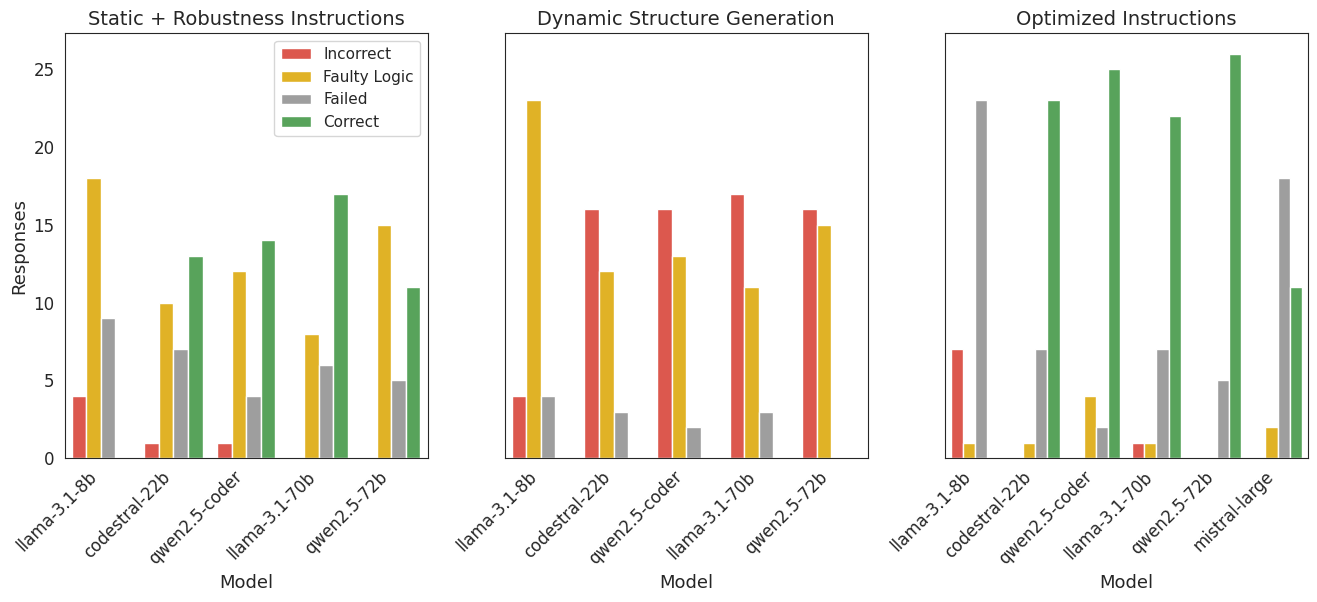

In [7]:
%pip install seaborn
%pip install jinja2
%pip install plotly
%pip install nbformat

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")

custom_order = [
    "llama-3.1-8b",
    "codestral-22b",
    "qwen2.5-coder",
    "llama-3.1-70b",
    "qwen2.5-72b",
    "mistral-large"
]

small_models = ["llama-3.1-8b", "codestral-22b", "qwen2.5-coder"]
large_models = ["llama-3.1-70b", "qwen2.5-72b", "mistral-large"]
model_groups = [small_models, large_models]

model_labels = {
    "meta-llama-3.1-8b-instruct": "llama-3.1-8b",
    "meta-llama-3.1-70b-instruct": "llama-3.1-70b",
    "mistral-large-instruct": "mistral-large",
    "qwen2.5-coder-32b-instruct": "qwen2.5-coder",
    "qwen2.5-72b-instruct": "qwen2.5-72b",
    "codestral-22b": "codestral-22b",
    "meta/llama-3.1-70b-instruct": "llama-3.1-70b",
}

def classify_f1(row):
    if pd.isna(row["F1"]):
        return "Failed"
    elif row["F1"] == 1.0:
        return "Completely Correct"
    elif row["F1"] > 0:
        return "Partially Correct"
    else:
        return "Incorrect"

color_map = {
    "Completely Correct": "#4CAF50",
    "Partially Correct": "#FFC107",
    "Incorrect": "#F44336",
    "Failed": "#B0B0B0"
}

f1_order = ["Completely Correct", "Failed", "Incorrect", "Partially Correct"]

experiment_dirs = ["First Experiment Prompt", "Second Experiment Prompt", "Third Experiment Prompt"]
experiment_titles = ["Static + Robustness Instructions", "Dynamic Structure Generation", "Optimized Instructions"]
dataframes = []

def classify_no_data_row(f1_processed, f1_nodata):
    def clamp01(x):
        if pd.isna(x): return x
        return max(0.0, min(1.0, float(x)))

    f1_p = clamp01(f1_processed)
    f1_n = clamp01(f1_nodata)

    # Failed: rerun on data produced no F1
    if pd.isna(f1_n):
        return "Failed"

    # Correct: processed==1 and produced a positive F1 on data (0,1]
    if f1_p == 1.0 and (0.0 < f1_n <= 1.0):
        return "Correct"

    # Faulty Logic: claimed perfect success on no-data, but failed on real data
    if f1_p == 1.0 and f1_n == 0.0:
        return "Faulty Logic"

    # Incorrect — No-Data Failure: cannot handle missing data at all
    if f1_p == 0.0 and f1_n >= 0.0:
        return "Incorrect"

    # Should not happen, but fallback
    return "Incorrect"


f1_order = ["Incorrect", "Faulty Logic", "Failed", "Correct"]

color_map = {
    "Correct": "#4CAF50",
    "Incorrect": "#F44336",
    "Faulty Logic": "#FFC107",
    "Failed": "#9E9E9E",
}

all_counts = []

for dir_label, title in zip(experiment_dirs, experiment_titles):
    nd_path = f"{dir_label}/nodata_results.csv"
    pr_path = f"{dir_label}/processed_result_evaluation_log.csv"

    df_nd = pd.read_csv(nd_path, na_values=["", " "])
    df_pr = pd.read_csv(pr_path, na_values=["", " "])

    df_nd["F1"] = pd.to_numeric(df_nd.get("F1"), errors="coerce")
    df_pr["F1"] = pd.to_numeric(df_pr.get("F1"), errors="coerce")

    join_cols = ["Experiment ID", "F1"]
    if "Experiment ID" not in df_nd.columns or "Experiment ID" not in df_pr.columns:
        raise KeyError("`Experiment ID` must exist in both nodata_results.csv and processed_result_evaluation_log.csv")

    merged = df_nd.merge(
        df_pr[join_cols].rename(columns={"F1": "F1_processed"}),
        on="Experiment ID",
        how="left",
    ).rename(columns={"F1": "F1_nodata"})

    if "Model" not in merged.columns:
        raise KeyError("`Model` column is required in nodata_results.csv")
    merged["Model"] = merged["Model"].map(model_labels).fillna(merged["Model"])

    merged["No-Data Outcome"] = merged.apply(
        lambda r: classify_no_data_row(r["F1_processed"], r["F1_nodata"]),
        axis=1
    )

    counts = (
        merged.groupby(["Model", "No-Data Outcome"])
        .size()
        .reset_index(name="Count")
    )
    counts["Experiment"] = title
    all_counts.append(counts)

outcome_df = pd.concat(all_counts, ignore_index=True)
outcome_df["Model"] = pd.Categorical(outcome_df["Model"], categories=custom_order, ordered=True)
outcome_df["No-Data Outcome"] = pd.Categorical(outcome_df["No-Data Outcome"], categories=f1_order, ordered=True)

fig, axes = plt.subplots(1, len(experiment_titles), figsize=(13.3, 6.8), sharey=True)

for i, title in enumerate(experiment_titles):
    subset = outcome_df[outcome_df["Experiment"] == title]

    model_order = [m for m in custom_order if m in subset["Model"].unique()]

    sns.barplot(
        data=subset,
        x="Model",
        y="Count",
        hue="No-Data Outcome",
        hue_order=f1_order,
        palette=color_map,
        ax=axes[i],
        order=model_order
    )
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("Model", fontsize=13)
    axes[i].set_ylabel("Responses" if i == 0 else "", fontsize=13)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == 0:
        axes[i].legend(loc="upper right", frameon=True, fontsize=11, title_fontsize=12)
    else:
        axes[i].legend_.remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Response Outcome Distribution per Model - No Data.png", dpi=600, bbox_inches='tight')
plt.show()

In [8]:
bucket_cols = ["Correct", "Incorrect", "Faulty Logic", "Failed"]

all_rows = []
for dir_label, title in zip(experiment_dirs, experiment_titles):
    nd_path = f"{dir_label}/nodata_results.csv"
    pr_path = f"{dir_label}/processed_result_evaluation_log.csv"

    df_nd = pd.read_csv(nd_path, na_values=["", " "])
    df_pr = pd.read_csv(pr_path, na_values=["", " "])

    df_nd["F1"] = pd.to_numeric(df_nd.get("F1"), errors="coerce")
    df_pr["F1"] = pd.to_numeric(df_pr.get("F1"), errors="coerce")

    if "Experiment ID" not in df_nd.columns or "Experiment ID" not in df_pr.columns:
        raise KeyError("`Experiment ID` must exist in both nodata_results.csv and processed_result_evaluation_log.csv")

    merged = df_nd.merge(
        df_pr[["Experiment ID", "F1"]].rename(columns={"F1": "F1_processed"}),
        on="Experiment ID",
        how="left"
    ).rename(columns={"F1": "F1_nodata"})

    merged["Model"] = merged["Model"].map(model_labels).fillna(merged["Model"])
    merged["Experiment"] = title

    merged["Bucket"] = merged.apply(lambda r: classify_no_data_row(r["F1_processed"], r["F1_nodata"]), axis=1)

    all_rows.append(merged[["Experiment", "Model", "Bucket"]])

df_4 = pd.concat(all_rows, ignore_index=True)

df_4["Model"] = pd.Categorical(df_4["Model"], categories=custom_order, ordered=True)
df_4["Experiment"] = pd.Categorical(df_4["Experiment"], categories=experiment_titles, ordered=True)

counts_exp = (
    df_4.groupby(["Experiment", "Model", "Bucket"])
        .size()
        .unstack(fill_value=0)
)

for col in bucket_cols:
    if col not in counts_exp.columns:
        counts_exp[col] = 0

counts_exp = counts_exp[bucket_cols]

counts_exp["Total"] = counts_exp[bucket_cols].sum(axis=1)

pct_exp = counts_exp.copy()
totals_nonzero = counts_exp["Total"].replace({0: pd.NA})
for col in bucket_cols:
    pct_exp[col] = ((counts_exp[col] / totals_nonzero) * 100).round(1).fillna(0.0)

for exp in experiment_titles:
    print(f"No-Data Handling — Percentages by Model — {exp}")
    if exp in pct_exp.index.get_level_values(0):
        df_show = pct_exp.loc[exp].reset_index()
        df_show = df_show.set_index("Model").reindex(custom_order).reset_index()
        display(df_show[["Model"] + bucket_cols + ["Total"]])
    else:
        template = pd.DataFrame(0.0, index=custom_order, columns=bucket_cols + ["Total"]).reset_index().rename(columns={"index":"Model"})
        display(template)

No-Data Handling — Percentages by Model — Static + Robustness Instructions


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.000000,12.903226,58.064516,29.032258,31
1,codestral-22b,41.935484,3.225806,32.258065,22.580645,31
2,qwen2.5-coder,45.161290,3.225806,38.709677,12.903226,31
3,llama-3.1-70b,54.838710,0.000000,25.806452,19.354839,31
4,qwen2.5-72b,35.483871,0.000000,48.387097,16.129032,31
5,mistral-large,0.000000,0.000000,0.000000,0.000000,0


No-Data Handling — Percentages by Model — Dynamic Structure Generation


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.0,12.903226,74.193548,12.903226,31
1,codestral-22b,0.0,51.612903,38.709677,9.677419,31
2,qwen2.5-coder,0.0,51.612903,41.935484,6.451613,31
3,llama-3.1-70b,0.0,54.838710,35.483871,9.677419,31
4,qwen2.5-72b,0.0,51.612903,48.387097,0.000000,31
5,mistral-large,0.0,0.000000,0.000000,0.000000,0


No-Data Handling — Percentages by Model — Optimized Instructions


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.000000,22.580645,3.225806,74.193548,31
1,codestral-22b,74.193548,0.000000,3.225806,22.580645,31
2,qwen2.5-coder,80.645161,0.000000,12.903226,6.451613,31
3,llama-3.1-70b,70.967742,3.225806,3.225806,22.580645,31
4,qwen2.5-72b,83.870968,0.000000,0.000000,16.129032,31
5,mistral-large,35.483871,0.000000,6.451613,58.064516,31


In [20]:
from IPython.display import display


counts_exp = df_4.groupby(["Experiment", "Bucket"]).size().unstack(fill_value=0)

for col in bucket_cols:
    if col not in counts_exp.columns:
        counts_exp[col] = 0

counts_exp = counts_exp[bucket_cols]
counts_exp["Total"] = counts_exp[bucket_cols].sum(axis=1)

# 
pct_exp = counts_exp.copy()
totals_nonzero = counts_exp["Total"].replace({0: pd.NA})
for col in bucket_cols:
    pct_exp[col] = ((counts_exp[col] / totals_nonzero) * 100).round(1).fillna(0.0)

print("No-Data Handling — Percentages per Experiment")
display(pct_exp.reset_index())

counts_model = df_4.groupby(["Model", "Bucket"]).size().unstack(fill_value=0)

for col in bucket_cols:
    if col not in counts_model.columns:
        counts_model[col] = 0

counts_model = counts_model[bucket_cols]
counts_model["Total"] = counts_model[bucket_cols].sum(axis=1)

pct_model = counts_model.copy()
totals_nonzero = counts_model["Total"].replace({0: pd.NA})
for col in bucket_cols:
    pct_model[col] = ((counts_model[col] / totals_nonzero) * 100).round(1).fillna(0.0)

print("No-Data Handling — Percentages per Model")
display(pct_model.reset_index())

No-Data Handling — Percentages per Experiment


Bucket,Experiment,Correct,Incorrect,Faulty Logic,Failed,Total
0,Static + Robustness Instructions,35.5,3.9,40.6,20.0,155
1,Dynamic Structure Generation,0.0,44.5,47.7,7.7,155
2,Optimized Instructions,57.5,4.3,4.8,33.3,186


No-Data Handling — Percentages per Model


Bucket,Model,Correct,Incorrect,Faulty Logic,Failed,Total
0,llama-3.1-8b,0.0,16.1,45.2,38.7,93
1,codestral-22b,38.7,18.3,24.7,18.3,93
2,qwen2.5-coder,41.9,18.3,31.2,8.6,93
3,llama-3.1-70b,41.9,19.4,21.5,17.2,93
4,qwen2.5-72b,39.8,17.2,32.3,10.8,93
5,mistral-large,35.5,0.0,6.5,58.1,31


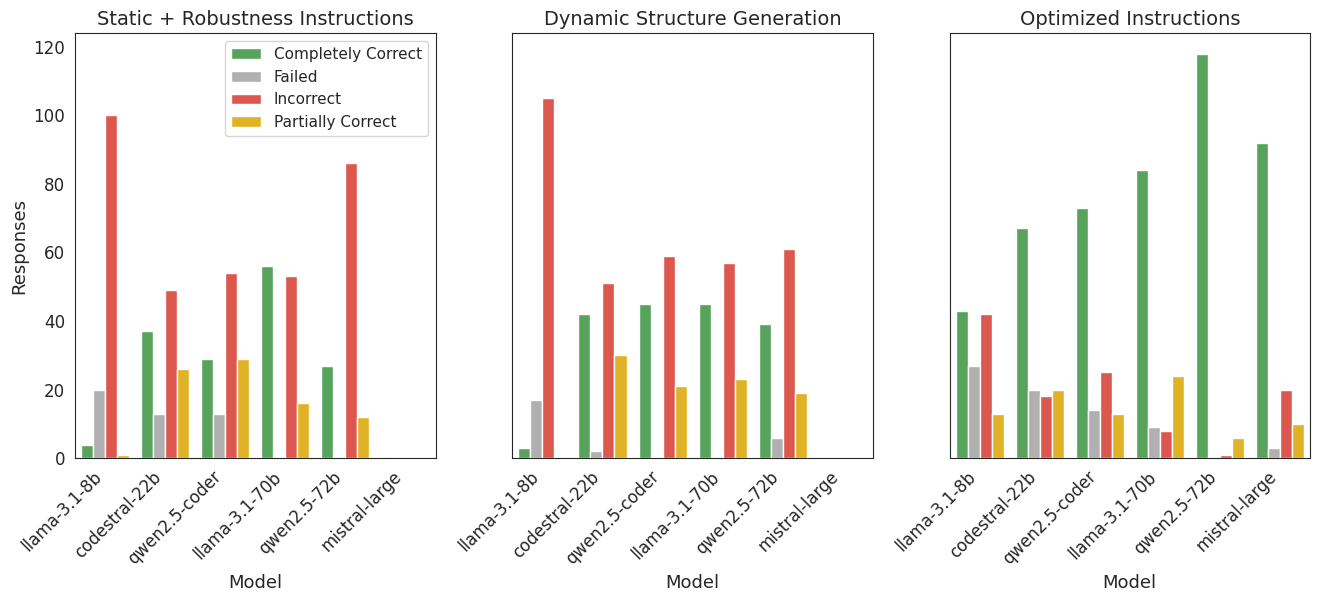

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

all_outcome_counts = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels)

    counts = (
        df.groupby(["Model", "F1 Outcome"])
        .size()
        .reset_index(name="Count")
    )
    counts["Experiment"] = label
    all_outcome_counts.append(counts)

outcome_df = pd.concat(all_outcome_counts)

outcome_df["Model"] = pd.Categorical(outcome_df["Model"], categories=custom_order, ordered=True)

color_map = {
    "Completely Correct": "#4CAF50",
    "Partially Correct": "#FFC107",
    "Incorrect": "#F44336",
    "Failed": "#B0B0B0"
}
fig, axes = plt.subplots(1, 3, figsize=(13.3, 6.8), sharey=True)

for i, label in enumerate(experiment_titles):
    subset = outcome_df[outcome_df["Experiment"] == label]

    sns.barplot(
        data=subset,
        x="Model",
        y="Count",
        hue="F1 Outcome",
        palette=color_map,
        ax=axes[i]
    )

    axes[i].set_title(label, fontsize=14)
    axes[i].set_xlabel("Model", fontsize=13)
    axes[i].set_ylabel("Responses" if i == 0 else "", fontsize=13)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == 0:
        axes[i].legend(
            loc="upper right",
            frameon=True,
            fontsize=11,
        )
    else:
        axes[i].legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Response Outcome Distribution per Model - With Data.png", dpi=600, bbox_inches='tight') 
plt.show()

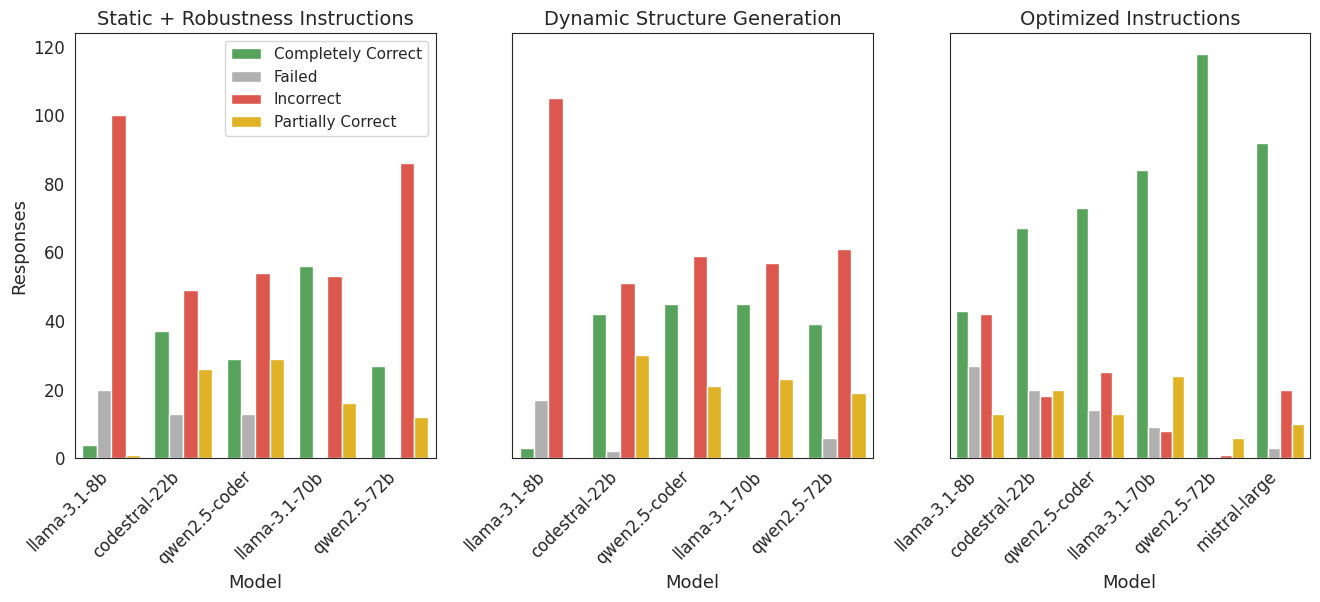

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(13.3, 6.8), sharey=True)

for i, label in enumerate(experiment_titles):
    subset = outcome_df[outcome_df["Experiment"] == label]

    model_order = [m for m in custom_order if m in subset["Model"].unique()]

    sns.barplot(
        data=subset,
        x="Model",
        y="Count",
        hue="F1 Outcome",
        palette=color_map,
        ax=axes[i],
        order=model_order
    )

    axes[i].set_title(label, fontsize=14)
    axes[i].set_xlabel("Model", fontsize=13)
    axes[i].set_ylabel("Responses" if i == 0 else "", fontsize=13)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == 0:
        axes[i].legend(
            loc="upper right",
            frameon=True,
            fontsize=11,
        )
    else:
        axes[i].legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Response Outcome Distribution per Model - With Data.png", dpi=600, bbox_inches='tight') 
plt.show()

In [22]:
all_outcome_counts = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Accuracy Bucket"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels)

    counts = (
        df.groupby(["Model", "Accuracy Bucket"])
        .size()
        .reset_index(name="Count")
    )
    counts["Experiment"] = label
    all_outcome_counts.append(counts)

outcome_df = pd.concat(all_outcome_counts)

outcome_df["Model"] = pd.Categorical(outcome_df["Model"], categories=custom_order, ordered=True)

model_acc = outcome_df.groupby(["Model", "Accuracy Bucket"])["Count"].sum().unstack(fill_value=0)
model_acc["Total"] = model_acc.sum(axis=1)

model_acc_pct = pd.DataFrame({
    "Completely Correct": (model_acc.get("Completely Correct", 0) / model_acc["Total"] * 100).round(1),
    "Partially Correct": (model_acc.get("Partially Correct", 0) / model_acc["Total"] * 100).round(1),
    "Incorrect": (model_acc.get("Incorrect", 0) / model_acc["Total"] * 100).round(1),
    "Failure": (model_acc.get("Failed", 0) / model_acc["Total"] * 100).round(1),
})

print("Accuracy Percentages by Model:")
display(model_acc_pct)

exp_acc = outcome_df.groupby(["Experiment", "Accuracy Bucket"])["Count"].sum().unstack(fill_value=0)
exp_acc["Total"] = exp_acc.sum(axis=1)

exp_acc_pct = pd.DataFrame({
    "Completely Correct": (exp_acc.get("Completely Correct", 0) / exp_acc["Total"] * 100).round(1),
    "Partially Correct": (exp_acc.get("Partially Correct", 0) / exp_acc["Total"] * 100).round(1),
    "Incorrect": (exp_acc.get("Incorrect", 0) / exp_acc["Total"] * 100).round(1),
    "Failure": (exp_acc.get("Failed", 0) / exp_acc["Total"] * 100).round(1),
})

print("Accuracy Percentages by Experiment:")
display(exp_acc_pct)

Accuracy Percentages by Model:


,Completely Correct,Partially Correct,Incorrect,Failure
Model,,,,
llama-3.1-8b,13.3,3.7,65.9,17.1
codestral-22b,38.9,20.3,31.5,9.3
qwen2.5-coder,39.2,16.8,36.8,7.2
llama-3.1-70b,49.3,16.8,31.5,2.4
qwen2.5-72b,49.1,9.9,39.5,1.6
mistral-large,73.6,8.0,16.0,2.4


Accuracy Percentages by Experiment:


,Completely Correct,Partially Correct,Incorrect,Failure
Experiment,,,,
Dynamic Structure Generation,27.8,14.9,53.3,4.0
Optimized Instructions,63.6,11.5,15.2,9.7
Static + Robustness Instructions,24.5,13.4,54.7,7.4


In [9]:
custom_order_cat = pd.CategoricalDtype(categories=custom_order, ordered=True)

def highlight_min_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        "background-color: #f28e8e" if minv else
        "background-color: #a8e6a3" if maxv else ""
        for minv, maxv in zip(is_min, is_max)
    ]

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Accuracy Bucket"] = df.apply(classify_f1, axis=1)
    df["Model"] = df["Model"].map(model_labels)

    model_acc = df.groupby(["Model", "Accuracy Bucket"]).size().unstack(fill_value=0)
    model_acc["Total"] = model_acc.sum(axis=1)

    model_acc_pct = pd.DataFrame()
    model_acc_pct["Completely Correct"] = (model_acc.get("Completely Correct", 0) / model_acc["Total"] * 100).round(1)
    model_acc_pct["Partially Correct"] = (model_acc.get("Partially Correct", 0) / model_acc["Total"] * 100).round(1)
    model_acc_pct["Incorrect"] = (model_acc.get("Incorrect", 0) / model_acc["Total"] * 100).round(1)
    model_acc_pct["Failure"] = (model_acc.get("Failed", 0) / model_acc["Total"] * 100).round(1)

    model_acc_pct.index = pd.CategoricalIndex(model_acc_pct.index, dtype=custom_order_cat)
    model_acc_pct = model_acc_pct.sort_index()

    styled_table = model_acc_pct.style.apply(highlight_min_max, axis=0)

    print(f"Accuracy Percentages by Model — {label}")
    display(styled_table)

📊 Accuracy Percentages by Model — Static + Robustness Instructions


,Completely Correct,Partially Correct,Inaccurate,Failure
Model,,,,
llama-3.1-8b,3.200000,0.800000,80.000000,16.000000
codestral-22b,29.600000,20.800000,39.200000,10.400000
qwen2.5-coder,23.200000,23.200000,43.200000,10.400000
llama-3.1-70b,44.800000,12.800000,42.400000,0.000000
qwen2.5-72b,21.600000,9.600000,68.800000,0.000000


📊 Accuracy Percentages by Model — Dynamic Structure Generation


,Completely Correct,Partially Correct,Inaccurate,Failure
Model,,,,
llama-3.1-8b,2.400000,0.000000,84.000000,13.600000
codestral-22b,33.600000,24.000000,40.800000,1.600000
qwen2.5-coder,36.000000,16.800000,47.200000,0.000000
llama-3.1-70b,36.000000,18.400000,45.600000,0.000000
qwen2.5-72b,31.200000,15.200000,48.800000,4.800000


📊 Accuracy Percentages by Model — Optimized Instructions


,Completely Correct,Partially Correct,Inaccurate,Failure
Model,,,,
llama-3.1-8b,34.400000,10.400000,33.600000,21.600000
codestral-22b,53.600000,16.000000,14.400000,16.000000
qwen2.5-coder,58.400000,10.400000,20.000000,11.200000
llama-3.1-70b,67.200000,19.200000,6.400000,7.200000
qwen2.5-72b,94.400000,4.800000,0.800000,0.000000
mistral-large,73.600000,8.000000,16.000000,2.400000


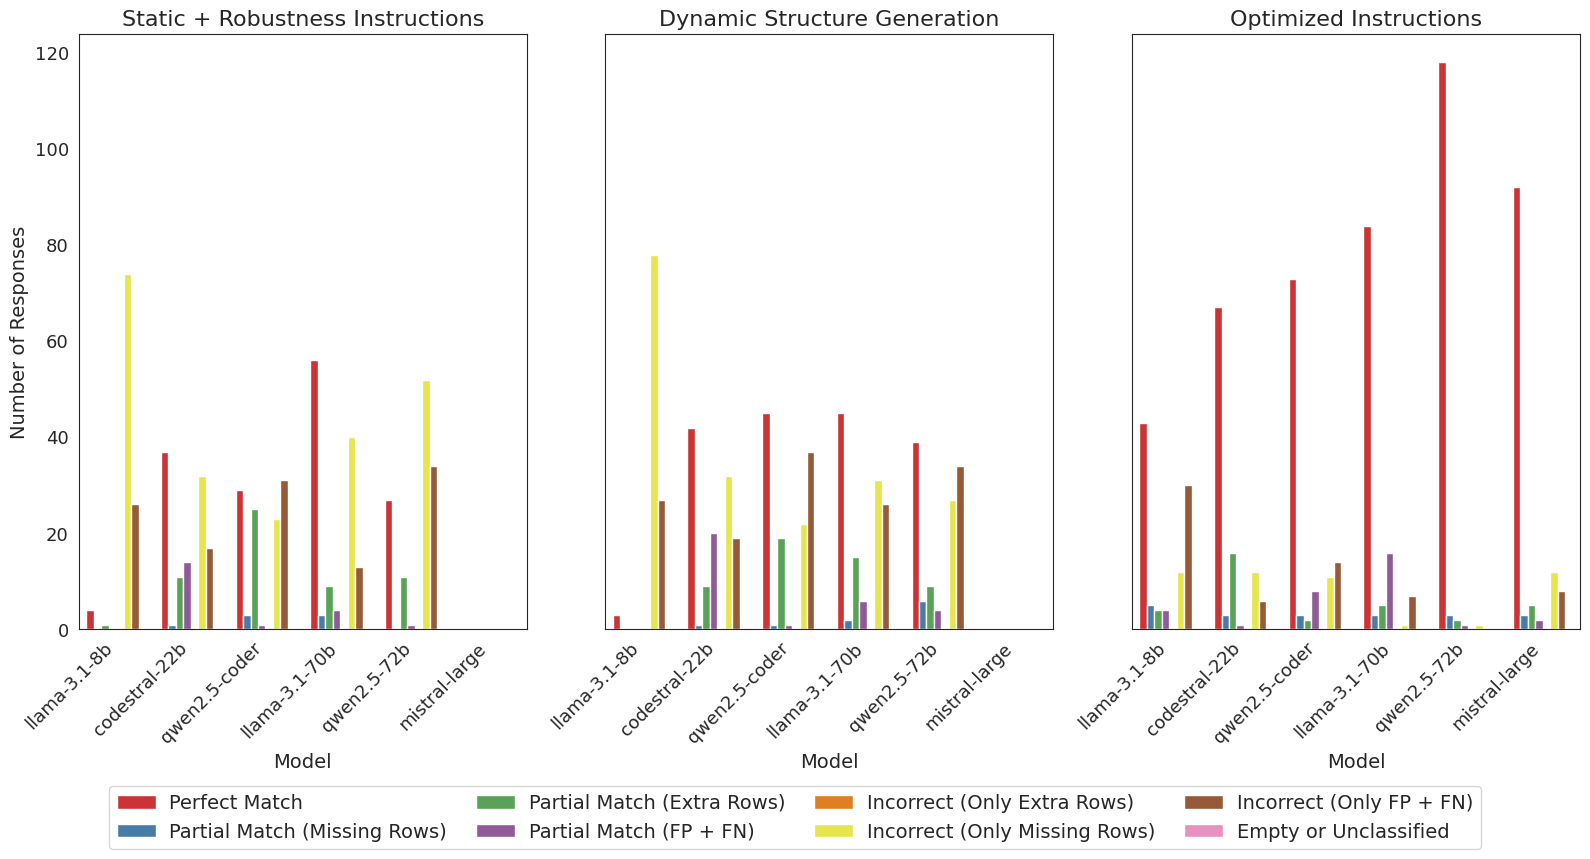

In [4]:
def classify_error(row):
    c, e, m = row["Correct Rows"], row["Extra Rows"], row["Missing Rows"]
    if c > 0 and e == 0 and m == 0:
        return "Perfect Match"
    elif c > 0 and e == 0 and m > 0:
        return "Partial Match (Missing Rows)"
    elif c > 0 and e > 0 and m == 0:
        return "Partial Match (Extra Rows)"
    elif c > 0 and e > 0 and m > 0:
        return "Partial Match (FP + FN)"
    elif c == 0 and e > 0 and m == 0:
        return "Incorrect (Only Extra Rows)"
    elif c == 0 and e == 0 and m > 0:
        return "Incorrect (Only Missing Rows)"
    elif c == 0 and e > 0 and m > 0:
        return "Incorrect (Only FP + FN)"
    else:
        return "Empty or Unclassified"

answer_type_order = [
    "Perfect Match",
    "Partial Match (Missing Rows)",
    "Partial Match (Extra Rows)",
    "Partial Match (FP + FN)",
    "Incorrect (Only Extra Rows)",
    "Incorrect (Only Missing Rows)",
    "Incorrect (Only FP + FN)",
    "Empty or Unclassified"
]

dataframes = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    
    df_filtered = df[df["F1 Outcome"] != "Failed"].copy()
    df_filtered["Answer Type"] = df_filtered.apply(classify_error, axis=1)
    df_filtered["Experiment"] = path
    dataframes.append(df_filtered)

df_all = pd.concat(dataframes, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

df_all["Answer Type"] = pd.Categorical(df_all["Answer Type"], categories=answer_type_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 9), sharey=True)

for i, title in enumerate(experiment_titles):
    df_plot = df_all[df_all["Experiment"] == experiment_dirs[i]]
    counts = df_plot.groupby(["Model", "Answer Type"]).size().reset_index(name="Count")
    
    sns.barplot(
        data=counts,
        x="Model",
        y="Count",
        hue="Answer Type",
        palette="Set1",
        hue_order=answer_type_order,
        ax=axes[i]
    )

    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel("Model", fontsize=14)
    axes[i].set_ylabel("Number of Responses" if i == 0 else "", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    axes[i].legend().remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    bbox_transform=fig.transFigure,
    ncol=4,
    columnspacing=1.5,
    handletextpad=0.7,
    fontsize=14,
    frameon=True
)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
#plt.savefig("Images/Answer Type Classification per Model Across Experiments.png", dpi=600, bbox_inches='tight')
plt.show()

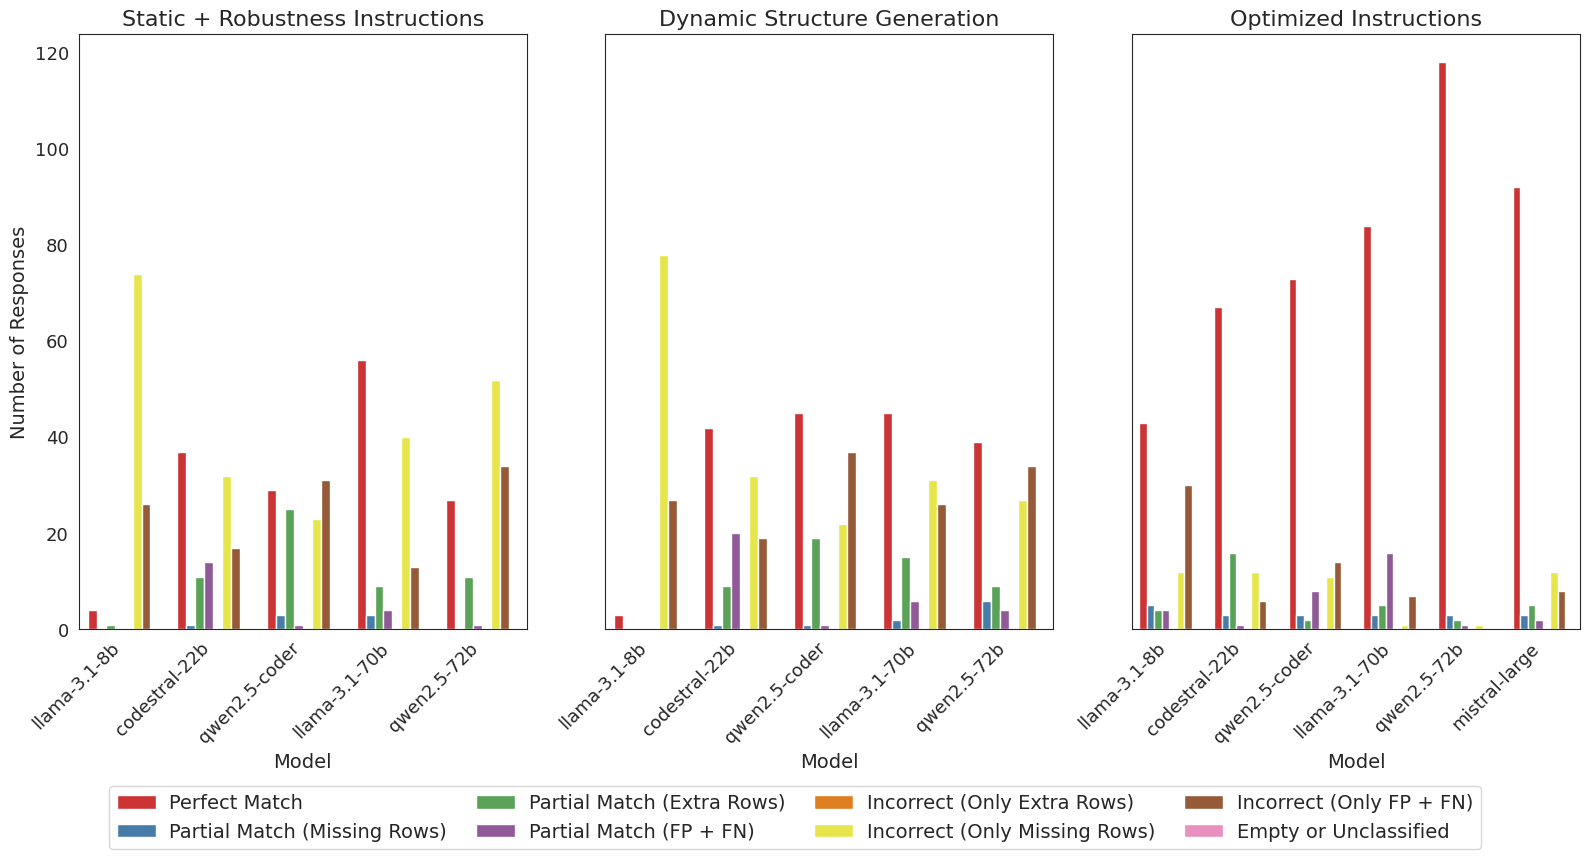

In [5]:
# keep classify_error and answer_type_order as-is

dataframes = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]

    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels).fillna(df["Model"])
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)

    df_filtered = df[df["F1 Outcome"] != "Failed"].copy()
    df_filtered["Answer Type"] = df_filtered.apply(classify_error, axis=1)
    df_filtered["Experiment"] = path
    dataframes.append(df_filtered)

df_all = pd.concat(dataframes, ignore_index=True)

df_all["Answer Type"] = pd.Categorical(df_all["Answer Type"], categories=answer_type_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 9), sharey=True)

for i, title in enumerate(experiment_titles):
    df_plot = df_all[df_all["Experiment"] == experiment_dirs[i]]
    counts = df_plot.groupby(["Model", "Answer Type"]).size().reset_index(name="Count")

    present_models = counts["Model"].dropna().unique().tolist()
    model_order = [m for m in custom_order if m in present_models]

    extras = [m for m in present_models if m not in model_order]
    model_order += sorted(extras)

    counts = counts[counts["Model"].isin(model_order)].copy()
    counts["Model"] = pd.Categorical(counts["Model"], categories=model_order, ordered=True)

    sns.barplot(
        data=counts,
        x="Model",
        y="Count",
        hue="Answer Type",
        palette="Set1",
        hue_order=answer_type_order,
        ax=axes[i],
        order=model_order
    )

    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel("Model", fontsize=14)
    axes[i].set_ylabel("Number of Responses" if i == 0 else "", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    axes[i].legend().remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    bbox_transform=fig.transFigure,
    ncol=4,
    columnspacing=1.5,
    handletextpad=0.7,
    fontsize=14,
    frameon=True
)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
#plt.savefig("Images/Answer Type Classification per Model Across Experiments.png", dpi=600, bbox_inches='tight')
plt.show()

In [6]:
type_to_outcome = {
    "Perfect Match": "Correct",
    "Partial Match (Missing Rows)": "Partially Correct",
    "Partial Match (Extra Rows)": "Partially Correct",
    "Partial Match (FP + FN)": "Partially Correct",
    "Incorrect (Only Extra Rows)": "Incorrect",
    "Incorrect (Only Missing Rows)": "Incorrect",
    "Incorrect (Only FP + FN)": "Incorrect",
    "Empty or Unclassified": "Incorrect"
}

dataframes = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    
    df_filtered = df[df["F1 Outcome"] != "Failed"].copy()
    df_filtered["Answer Type"] = df_filtered.apply(classify_error, axis=1)
    df_filtered["Experiment"] = path
    dataframes.append(df_filtered)

df_all = pd.concat(dataframes, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

df_all["Answer Type"] = pd.Categorical(df_all["Answer Type"], categories=answer_type_order, ordered=True)

# Use to get insights into individual experiments
# df_all = df_all[df_all["Experiment"] == experiment_dirs[2]]

df_all["Outcome Bucket"] = df_all["Answer Type"].map(type_to_outcome)

model_summary = df_all.groupby(["Model", "Outcome Bucket"]).size().unstack(fill_value=0)
model_summary["Total"] = model_summary.sum(axis=1)
model_summary["% Correct"] = (model_summary["Correct"] / model_summary["Total"] * 100).round(1)
model_summary["% Partial"] = (model_summary["Partially Correct"] / model_summary["Total"] * 100).round(1)
model_summary["% Incorrect"] = (model_summary["Incorrect"] / model_summary["Total"] * 100).round(1)

model_summary = model_summary[["Correct", "Partially Correct", "Incorrect", "Total", "% Correct", "% Partial", "% Incorrect"]]

print("Summary by Model:")
display(model_summary)

exp_summary = df_all.groupby(["Experiment", "Outcome Bucket"]).size().unstack(fill_value=0)
exp_summary["Total"] = exp_summary.sum(axis=1)
exp_summary["% Correct"] = (exp_summary["Correct"] / exp_summary["Total"] * 100).round(1)
exp_summary["% Partial"] = (exp_summary["Partially Correct"] / exp_summary["Total"] * 100).round(1)
exp_summary["% Incorrect"] = (exp_summary["Incorrect"] / exp_summary["Total"] * 100).round(1)

exp_summary = exp_summary[["Correct", "Partially Correct", "Incorrect", "Total", "% Correct", "% Partial", "% Incorrect"]]

display(exp_summary)

Summary by Model:


Outcome Bucket,Correct,Partially Correct,Incorrect,Total,% Correct,% Partial,% Incorrect
Model,,,,,,,
llama-3.1-8b,50,14,247,311,16.1,4.5,79.4
codestral-22b,146,76,118,340,42.9,22.4,34.7
qwen2.5-coder,147,63,138,348,42.2,18.1,39.7
llama-3.1-70b,185,63,118,366,50.5,17.2,32.2
qwen2.5-72b,184,37,148,369,49.9,10.0,40.1
mistral-large,92,10,20,122,75.4,8.2,16.4


Outcome Bucket,Correct,Partially Correct,Incorrect,Total,% Correct,% Partial,% Incorrect
Experiment,,,,,,,
First Experiment Prompt,153,84,342,579,26.4,14.5,59.1
Second Experiment Prompt,174,93,333,600,29.0,15.5,55.5
Third Experiment Prompt,477,86,114,677,70.5,12.7,16.8


In [39]:
model_answer_counts = df_all.groupby(["Model", "Answer Type"]).size().unstack(fill_value=0)

model_answer_pct = model_answer_counts.div(model_answer_counts.sum(axis=1), axis=0) * 100

model_answer_pct = model_answer_pct.round(1)

print("Percentage Summary by Model (Detailed Answer Types):")
display(model_answer_pct)

exp_answer_counts = df_all.groupby(["Experiment", "Answer Type"]).size().unstack(fill_value=0)

exp_answer_pct = exp_answer_counts.div(exp_answer_counts.sum(axis=1), axis=0) * 100

exp_answer_pct = exp_answer_pct.round(1)

print("Percentage Summary by Experiment (Detailed Answer Types):")
display(exp_answer_pct)

Percentage Summary by Model (Detailed Answer Types):


Answer Type,Perfect Match,Partial Match (Missing Rows),Partial Match (Extra Rows),Partial Match (FP + FN),Incorrect (Only Extra Rows),Incorrect (Only Missing Rows),Incorrect (Only FP + FN),Empty or Unclassified
Model,,,,,,,,
llama-3.1-8b,16.1,1.6,1.6,1.3,0.0,52.7,26.7,0.0
codestral-22b,42.9,1.5,10.6,10.3,0.0,22.4,12.4,0.0
qwen2.5-coder,42.2,2.0,13.2,2.9,0.0,16.1,23.6,0.0
llama-3.1-70b,50.5,2.2,7.9,7.1,0.0,19.7,12.6,0.0
qwen2.5-72b,49.9,2.4,6.0,1.6,0.0,21.7,18.4,0.0
mistral-large,75.4,2.5,4.1,1.6,0.0,9.8,6.6,0.0


Percentage Summary by Experiment (Detailed Answer Types):


Answer Type,Perfect Match,Partial Match (Missing Rows),Partial Match (Extra Rows),Partial Match (FP + FN),Incorrect (Only Extra Rows),Incorrect (Only Missing Rows),Incorrect (Only FP + FN),Empty or Unclassified
Experiment,,,,,,,,
First Experiment Prompt,26.4,1.2,9.8,3.5,0.0,38.2,20.9,0.0
Second Experiment Prompt,29.0,1.7,8.7,5.2,0.0,31.7,23.8,0.0
Third Experiment Prompt,70.5,3.0,5.0,4.7,0.0,7.2,9.6,0.0


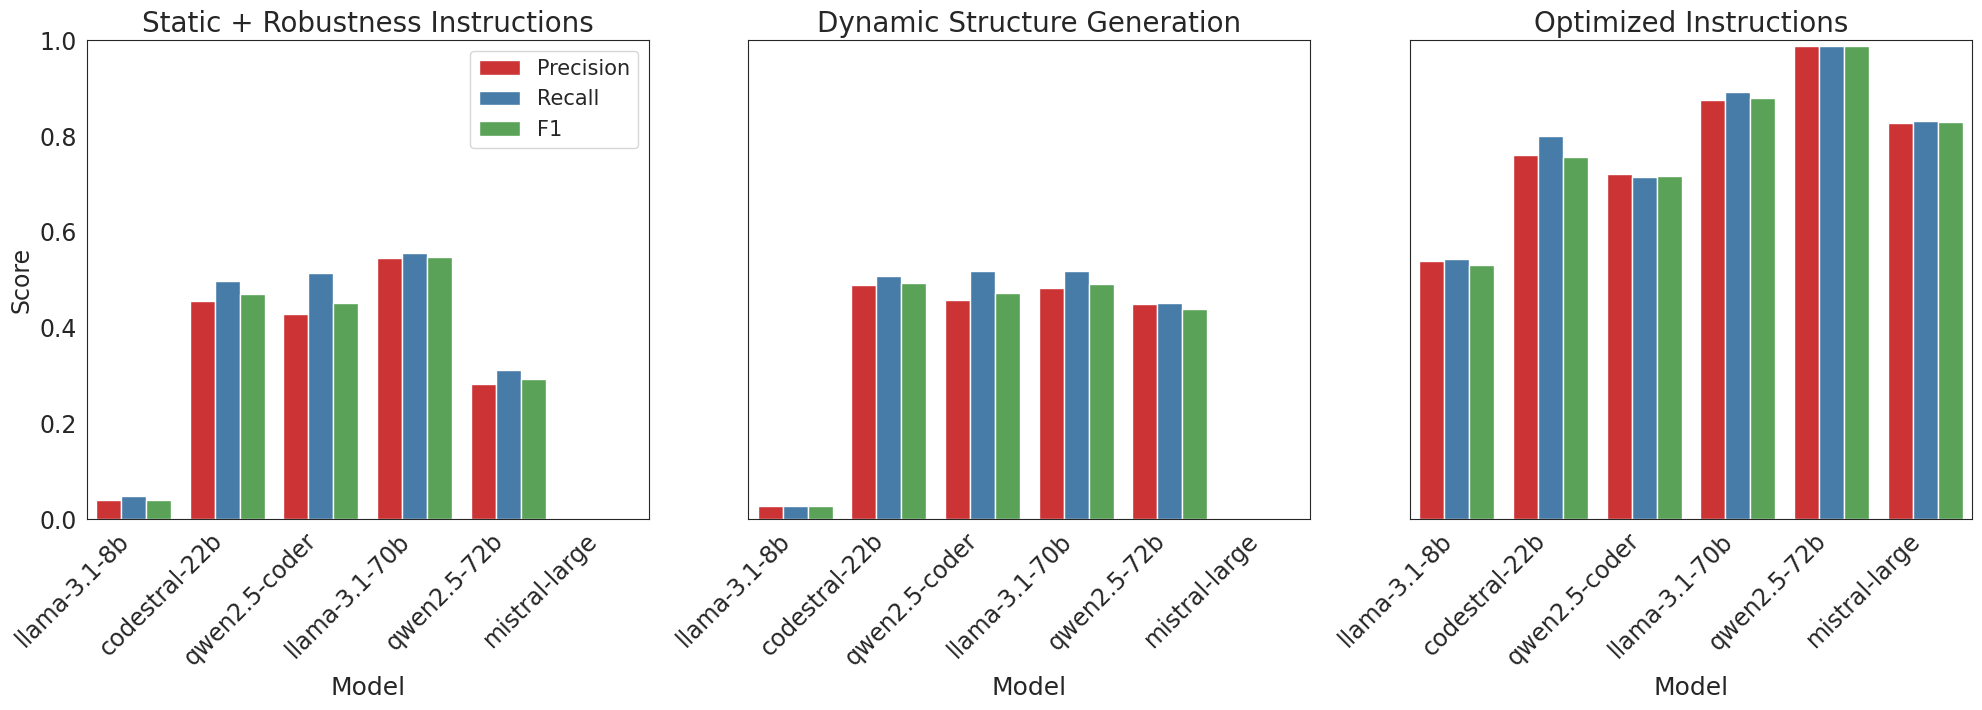

In [68]:
all_bars = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]

    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Precision"] = pd.to_numeric(df["Precision"], errors='coerce')
    df["Recall"] = pd.to_numeric(df["Recall"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels)

    df_all = df[df["F1 Outcome"] != "Failed"]
    summary_all = df_all.groupby("Model")[["Precision", "Recall", "F1"]].mean().reset_index()
    melted_all = summary_all.melt(id_vars="Model", value_vars=["Precision", "Recall", "F1"],
                                  var_name="Metric", value_name="Score")
    melted_all["Experiment"] = label
    all_bars.append(melted_all)

all_melted = pd.concat(all_bars)

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for i, label in enumerate(experiment_titles):
    subset_all = all_melted[all_melted["Experiment"] == label]
    
    sns.barplot(
        data=subset_all,
        x="Model",
        y="Score",
        hue="Metric",
        palette="Set1",
        ax=axes[i],
        order=custom_order
    )
    
    axes[i].set_title(f"{label}", fontsize=20)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45, labelsize=17)
    axes[i].tick_params(axis='y', labelsize=17)
    axes[i].set_xlabel("Model", fontsize=18)
    axes[i].set_ylabel("Score" if i == 0 else "", fontsize=17)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(loc="upper right", frameon=True, fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Evaluation of Model Performance Across Experiments.png", dpi=600, bbox_inches='tight')
plt.show()

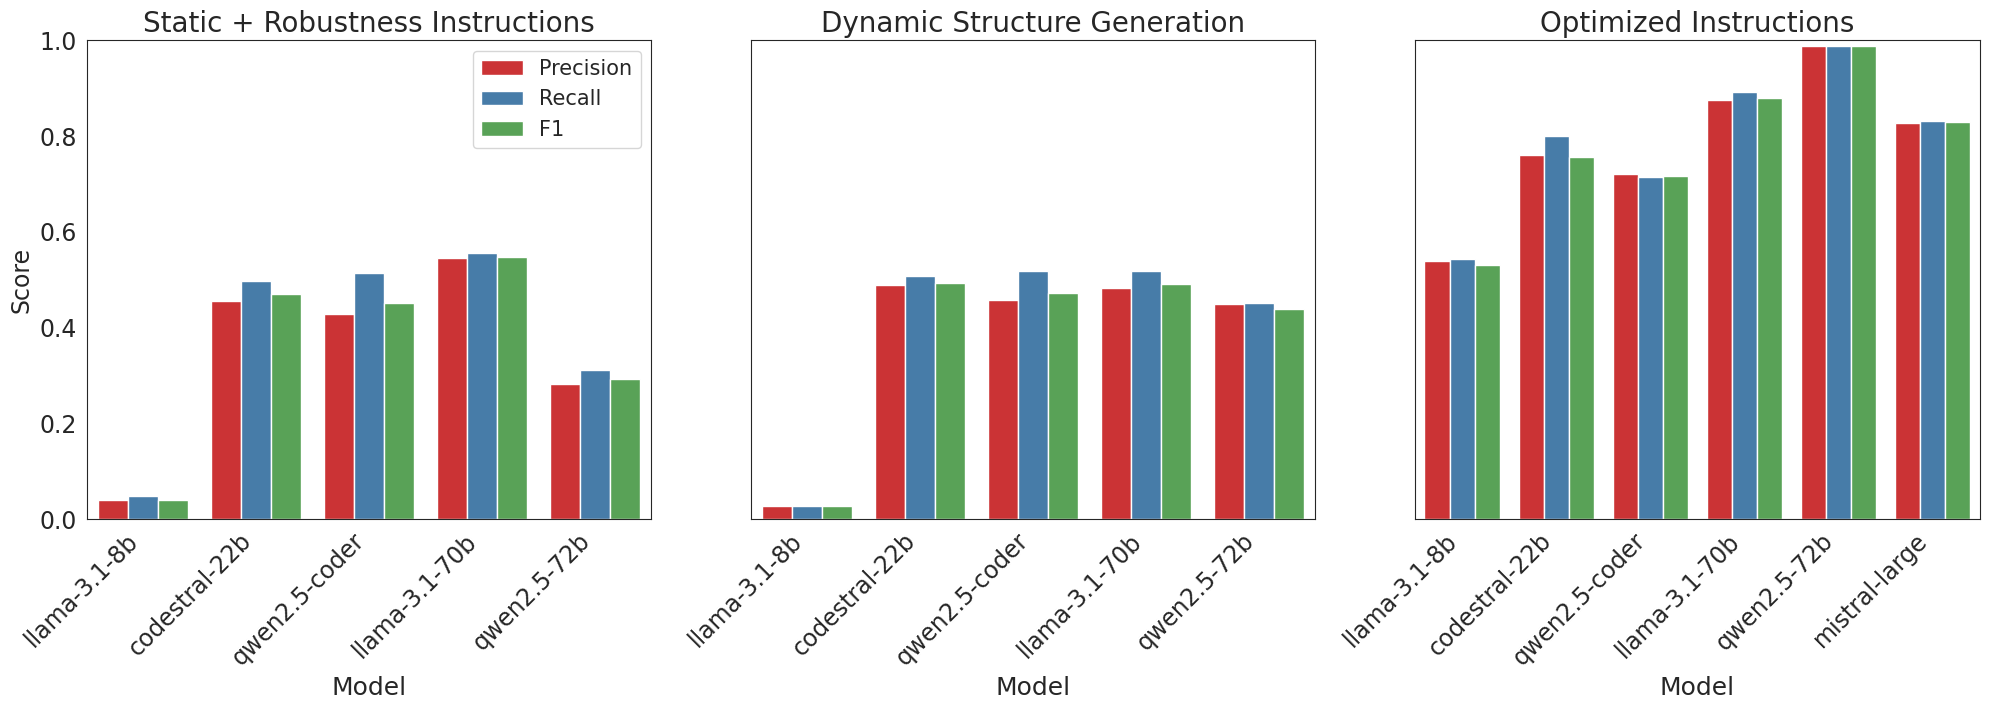

In [67]:
all_bars = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]

    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Precision"] = pd.to_numeric(df["Precision"], errors='coerce')
    df["Recall"] = pd.to_numeric(df["Recall"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Experiment"] = label
    df["Model"] = df["Model"].map(model_labels).fillna(df["Model"])  # keep unmapped names

    df_all = df[df["F1 Outcome"] != "Failed"]
    summary_all = df_all.groupby("Model")[["Precision", "Recall", "F1"]].mean().reset_index()
    melted_all = summary_all.melt(
        id_vars="Model",
        value_vars=["Precision", "Recall", "F1"],
        var_name="Metric",
        value_name="Score"
    )
    melted_all["Experiment"] = label
    all_bars.append(melted_all)

all_melted = pd.concat(all_bars, ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

for i, label in enumerate(experiment_titles):
    subset_all = all_melted[all_melted["Experiment"] == label].copy()

    present = subset_all["Model"].dropna().unique().tolist()
    model_order = [m for m in custom_order if m in present]

    subset_all = subset_all[subset_all["Model"].isin(model_order)].copy()
    subset_all["Model"] = pd.Categorical(subset_all["Model"], categories=model_order, ordered=True)

    sns.barplot(
        data=subset_all,
        x="Model",
        y="Score",
        hue="Metric",
        hue_order=["Precision", "Recall", "F1"],
        palette="Set1",
        ax=axes[i],
        order=model_order
    )

    axes[i].set_title(f"{label}", fontsize=20)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45, labelsize=17)
    axes[i].tick_params(axis='y', labelsize=17)
    axes[i].set_xlabel("Model", fontsize=18)
    axes[i].set_ylabel("Score" if i == 0 else "", fontsize=17)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i != 0:
        axes[i].legend().remove()
    else:
        axes[i].legend(loc="upper right", frameon=True, fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
#plt.savefig("Images/Evaluation of Model Performance Across Experiments.png", dpi=600, bbox_inches='tight')
plt.show()

In [28]:
summary_tables = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]

    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Model"] = df["Model"].map(model_labels)

    df_filtered = df[df["F1 Outcome"] != "Failed"]

    grouped = df_filtered.groupby("Model")["F1"].agg(["mean", "std"]).reset_index()
    grouped["F1 Summary"] = grouped.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)
    grouped["Experiment"] = label

    summary_tables.append(grouped[["Model", "F1 Summary", "Experiment"]])

summary_df = pd.concat(summary_tables)
summary_pivot = summary_df.pivot(index="Model", columns="Experiment", values="F1 Summary")

summary_pivot = summary_pivot.reindex(custom_order)
summary_pivot = summary_pivot[experiment_titles]

summary_pivot = summary_pivot.fillna("–")
display(summary_pivot)

Experiment,Static + Robustness Instructions,Dynamic Structure Generation,Optimized Instructions
Model,,,
llama-3.1-8b,0.04 ± 0.19,0.03 ± 0.17,0.53 ± 0.48
codestral-22b,0.47 ± 0.47,0.49 ± 0.47,0.76 ± 0.39
qwen2.5-coder,0.45 ± 0.46,0.47 ± 0.48,0.72 ± 0.43
llama-3.1-70b,0.55 ± 0.49,0.49 ± 0.48,0.88 ± 0.28
qwen2.5-72b,0.29 ± 0.44,0.44 ± 0.48,0.99 ± 0.09
mistral-large,–,–,0.83 ± 0.37


In [42]:
all_runs = []

for dir_label, title in zip(experiment_dirs, experiment_titles):
    pr_path = f"{dir_label}/processed_result_evaluation_log.csv"
    df_pr = pd.read_csv(pr_path, na_values=["", " "])

    for col in ["Precision", "Recall", "F1"]:
        df_pr[col] = pd.to_numeric(df_pr[col], errors="coerce")

    if "Model" not in df_pr.columns:
        raise KeyError("`Model` column is required in processed_result_evaluation_log.csv")
    df_pr["Model"] = df_pr["Model"].map(model_labels).fillna(df_pr["Model"])

    df_pr["Experiment"] = title
    df_pr["F1 Outcome"] = df_pr.apply(classify_f1, axis=1)

    all_runs.append(df_pr)

df_all = pd.concat(all_runs, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

df_metrics = df_all[df_all["F1 Outcome"] != "Failed"]

model_exp_metrics = (
    df_metrics.groupby(["Model", "Experiment"])[["Precision", "Recall", "F1"]]
    .mean()
    .round(3)
    .reset_index()
)

def highlight_min_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return [
        "background-color: #f28e8e" if minv else
        "background-color: #a8e6a3" if maxv else ""
        for minv, maxv in zip(is_min, is_max)
    ]

for exp in experiment_titles:
    print(f"Experiment: {exp}")
    df_exp = (
        model_exp_metrics[model_exp_metrics["Experiment"] == exp]
        .drop(columns=["Experiment"])
        .set_index("Model")
        .reindex(custom_order)
    )
    styled_table = df_exp.style.apply(highlight_min_max, axis=0)
    display(styled_table)

Experiment: Static + Robustness Instructions


,Precision,Recall,F1
Model,,,
llama-3.1-8b,0.217000,0.224000,0.218000
codestral-22b,0.566000,0.599000,0.578000
qwen2.5-coder,0.546000,0.613000,0.564000
llama-3.1-70b,0.629000,0.638000,0.632000
qwen2.5-72b,0.424000,0.449000,0.433000
mistral-large,nan,nan,nan


Experiment: Dynamic Structure Generation


,Precision,Recall,F1
Model,,,
llama-3.1-8b,0.193000,0.193000,0.193000
codestral-22b,0.469000,0.484000,0.472000
qwen2.5-coder,0.457000,0.505000,0.469000
llama-3.1-70b,0.477000,0.504000,0.483000
qwen2.5-72b,0.457000,0.459000,0.448000
mistral-large,nan,nan,nan


Experiment: Optimized Instructions


,Precision,Recall,F1
Model,,,
llama-3.1-8b,0.499000,0.502000,0.492000
codestral-22b,0.813000,0.844000,0.810000
qwen2.5-coder,0.779000,0.774000,0.775000
llama-3.1-70b,0.895000,0.908000,0.899000
qwen2.5-72b,0.991000,0.991000,0.991000
mistral-large,0.849000,0.851000,0.850000


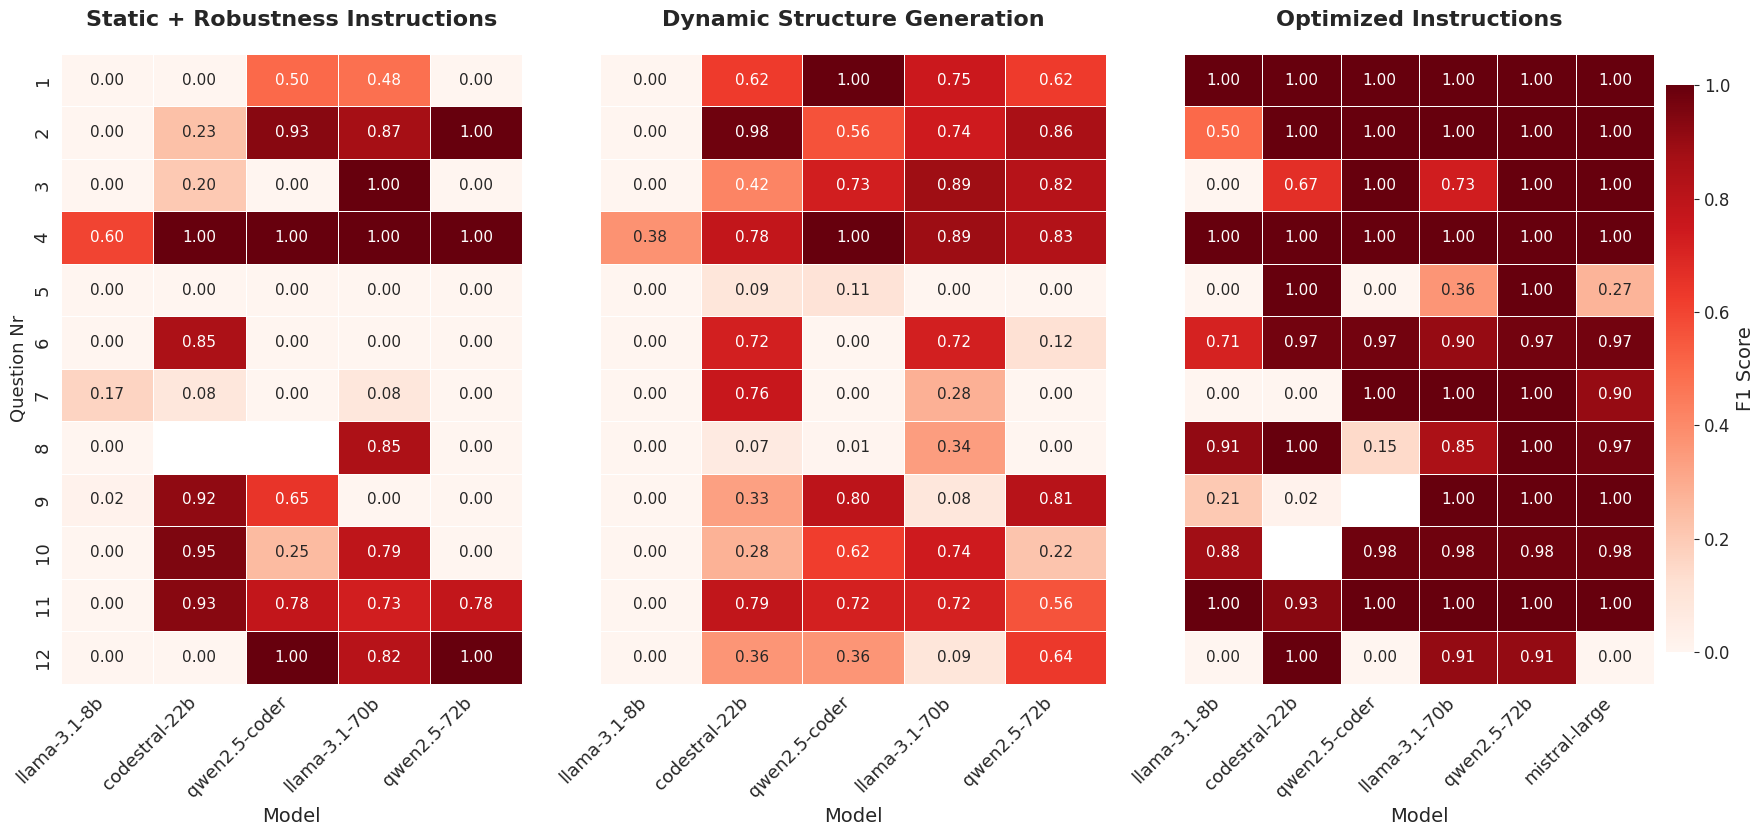

In [44]:
queries = [
    "What topics does Instagram determine to be of interest for a user?",
    "How often does a user see advertisements and about which topics (from which companies)?",
    "How often do people see posts(daily and weekly)?",
    "Which companies have access to your Instagram activity or information?",
    "Which devices has the user logged in from and when?",
    "What Instagram account changes (e.g., name, phone, email) has the user made over time?",
    "Whose stories does the user tend to engage with most often?",
    "Which accounts has the user interacted with most often through post likes, story likes and comments(Top 20)?",
    "Which profiles does the user follow that do not follow him back?",
    "How often does the user view content (including both posts and videos) and from which accounts?",
    "Which accounts has the user viewed posts from but not liked them?",
    "How many messages does the user send per week?"
]
query_map = {q: i+1 for i, q in enumerate(queries)}

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 9),
    sharey=True,
    gridspec_kw={'width_ratios': [1, 1.1, 1.23]}
)

for i, (label, path) in enumerate(zip(experiment_titles, experiment_dirs)):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Question Nr"] = df["Question"].map(query_map)
    df["Model"] = df["Model"].map(model_labels)

    df_success = df[df["F1"].notna() & (df["F1"] >= 0)]
    pivot = df_success.pivot_table(
        index="Question Nr", 
        columns="Model", 
        values="F1", 
        aggfunc="mean"
    )

    available_models = [m for m in custom_order if m in pivot.columns]
    pivot = pivot.reindex(index=range(1, 13), columns=available_models)

    sns.heatmap(
        pivot,
        ax=axes[i],
        cmap="Reds",
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        linecolor="white",
        cbar=(i == 2),
        cbar_kws={
            "label": "F1 Score",
            "shrink": 0.9,
            "aspect": 20,
            "pad": 0.02
        } if i == 2 else None,
        annot_kws={"fontsize": 11}
    )

    if i == 2:
        cbar = axes[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label("F1 Score", fontsize=14) 

    axes[i].set_title(label, fontsize=16, fontweight="bold", pad=20)
    axes[i].set_xlabel("Model", fontsize=14)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment("right")

    if i == 0:
        axes[i].set_ylabel("Question Nr", fontsize=13)
    else:
        axes[i].set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#plt.savefig("Images/F1 Score Heatmaps (Model × Question).png", dpi=600, bbox_inches='tight') 
plt.show()

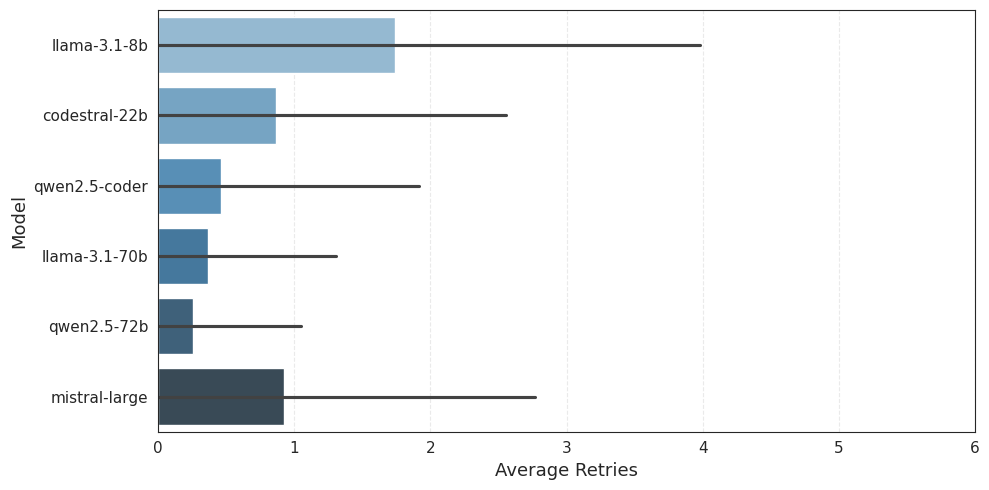

In [45]:
all_dfs = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df["Number of Retries"] = pd.to_numeric(df["Number of Retries"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)
    all_dfs.append(df)

df_retry = pd.concat(all_dfs, ignore_index=True)

df_retry["Model"] = pd.Categorical(df_retry["Model"], categories=custom_order, ordered=True)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_retry,
    x="Number of Retries",
    y="Model",
    estimator="mean",
    ci="sd",
    palette="Blues_d"
)

plt.xlabel("Average Retries", fontsize=13)
plt.ylabel("Model", fontsize=13)
plt.xlim(0, 6)  # Adjust based on your max
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.savefig("Images/Average Number of Retries per Model .png", dpi=600, bbox_inches='tight') 
plt.show()

In [46]:
retry_summary_tables = []

for label, path in zip(experiment_titles, experiment_dirs):
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df["Number of Retries"] = pd.to_numeric(df["Number of Retries"], errors='coerce')
    df["Model"] = df["Model"].map(model_labels)

    grouped = df.groupby("Model")["Number of Retries"].agg(["mean", "std"]).reset_index()
    grouped["Retry Summary"] = grouped.apply(lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1)
    grouped["Experiment"] = label

    retry_summary_tables.append(grouped[["Model", "Retry Summary", "Experiment"]])

retry_summary_df = pd.concat(retry_summary_tables)

retry_summary_pivot = retry_summary_df.pivot(index="Model", columns="Experiment", values="Retry Summary")

retry_summary_pivot = retry_summary_pivot.reindex(custom_order)
retry_summary_pivot = retry_summary_pivot[experiment_titles]

retry_summary_pivot = retry_summary_pivot.fillna("–")
display(retry_summary_pivot)

Experiment,Static + Robustness Instructions,Dynamic Structure Generation,Optimized Instructions
Model,,,
llama-3.1-8b,1.29 ± 2.06,1.53 ± 2.03,2.40 ± 2.46
codestral-22b,1.02 ± 1.77,0.40 ± 1.01,1.18 ± 2.03
qwen2.5-coder,0.59 ± 1.66,0.12 ± 0.39,0.67 ± 1.82
llama-3.1-70b,0.22 ± 0.43,0.31 ± 0.53,0.58 ± 1.46
qwen2.5-72b,0.17 ± 0.40,0.32 ± 1.18,0.27 ± 0.58
mistral-large,–,–,0.92 ± 1.84


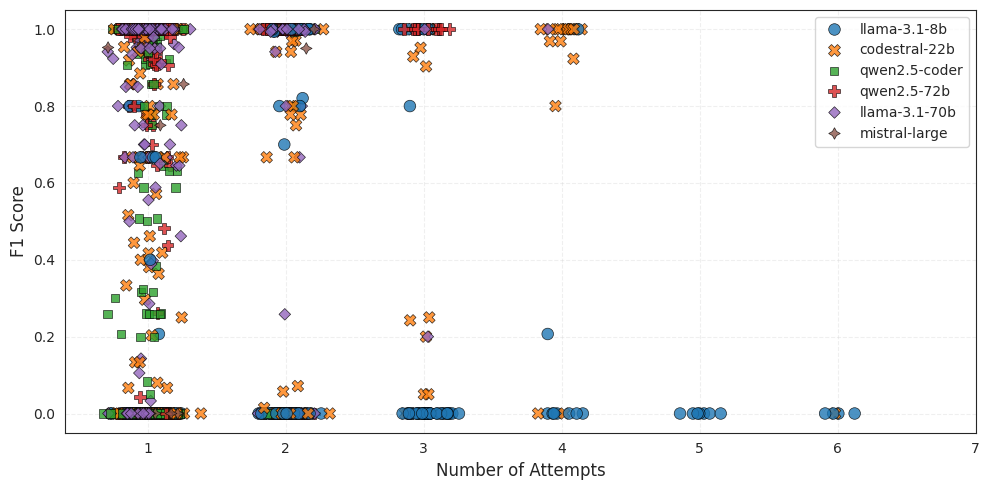

In [48]:
import numpy as np

all_dfs = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df = df[df["No Data"] == False]
    df["F1"] = pd.to_numeric(df["F1"], errors='coerce')
    df["Number of Retries"] = pd.to_numeric(df["Number of Retries"], errors='coerce')
    df["F1 Outcome"] = df.apply(classify_f1, axis=1)
    df["Model"] = df["Model"].map(model_labels)
    all_dfs.append(df)

df_combined = pd.concat(all_dfs, ignore_index=True)
df_filtered_all = df_combined[df_combined["F1 Outcome"] != "Failed"].copy()

# Apply jitter to make scatter plot clearer
np.random.seed(42)
df_filtered_all["Retries Jittered"] = df_filtered_all["Number of Retries"] + np.random.normal(0, 0.1, size=len(df_filtered_all))

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df_filtered_all,
    x="Retries Jittered",
    y="F1",
    hue="Model",
    style="Model",
    palette="tab10",
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5,
    s=70
)

plt.xlabel("Number of Attempts", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.xticks(ticks=range(0, 7), labels=[str(i + 1) for i in range(0, 7)])
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()
#plt.savefig("Images/Number of Retries vs F1 Score.png", dpi=600, bbox_inches='tight') 
plt.show()

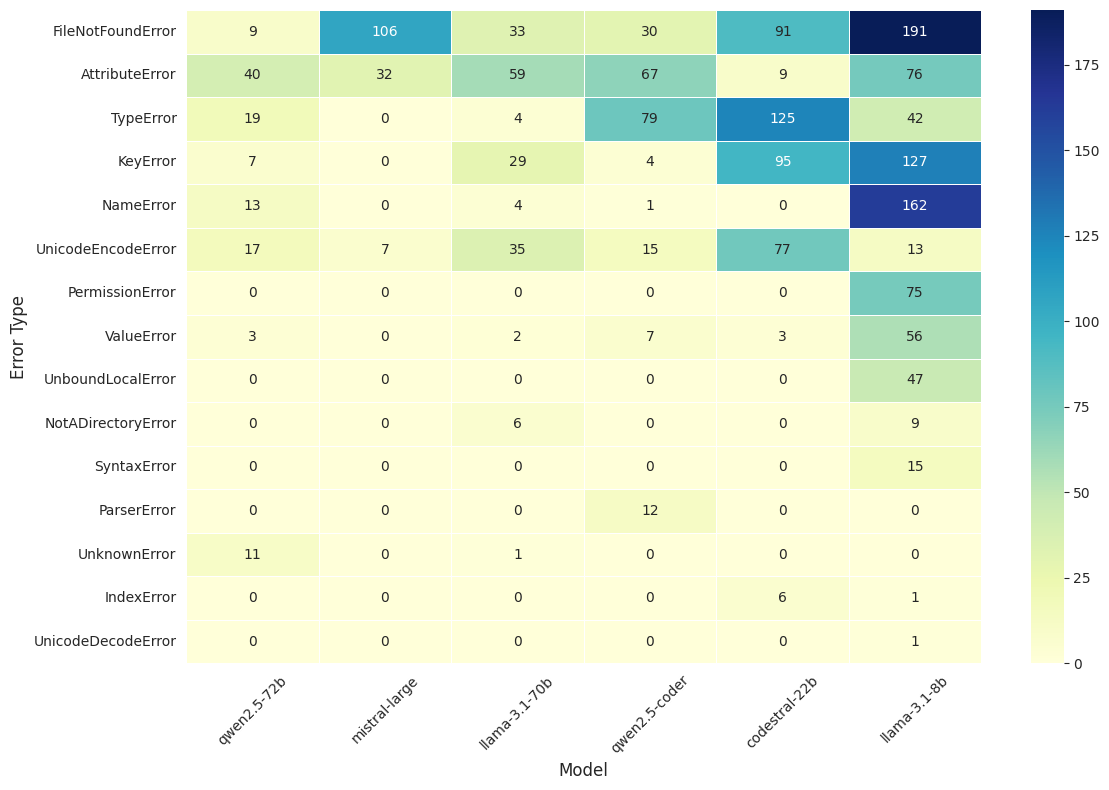

In [3]:
error_dfs = []

for path in experiment_dirs:
    df_error = pd.read_csv(f"{path}/processed_error_log.csv")
    df_error["Model"] = df_error["Model"].map(model_labels)
    error_dfs.append(df_error)

df_errors_all = pd.concat(error_dfs, ignore_index=True)

error_counts = (
    df_errors_all.groupby(["Error Type", "Model"])
    .size()
    .reset_index(name="Count")
)

heatmap_data = error_counts.pivot(index="Error Type", columns="Model", values="Count").fillna(0)

row_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
col_totals = heatmap_data.sum(axis=0).sort_values(ascending=True)

heatmap_sorted = heatmap_data.loc[row_totals.index, col_totals.index]

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_sorted,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white"
)

plt.xlabel("Model", fontsize=12)
plt.ylabel("Error Type", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("Images/Error Type Frequency per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from matplotlib.lines import Line2D

error_dfs = []
for label, path in zip(experiment_titles, experiment_dirs):
    df_err = pd.read_csv(f"{path}/processed_error_log.csv", na_values=["", " "])
    df_err["Experiment"] = label
    df_err["Model"] = df_err["Model"].map(model_labels)
    # make sure numeric
    if "Attempt Number" in df_err.columns:
        df_err["Attempt Number"] = pd.to_numeric(df_err["Attempt Number"], errors="coerce").fillna(0).astype(int)
    error_dfs.append(df_err)

df_errors = pd.concat(error_dfs, ignore_index=True)

df_errors["Model"] = pd.Categorical(df_errors["Model"], categories=custom_order, ordered=True)

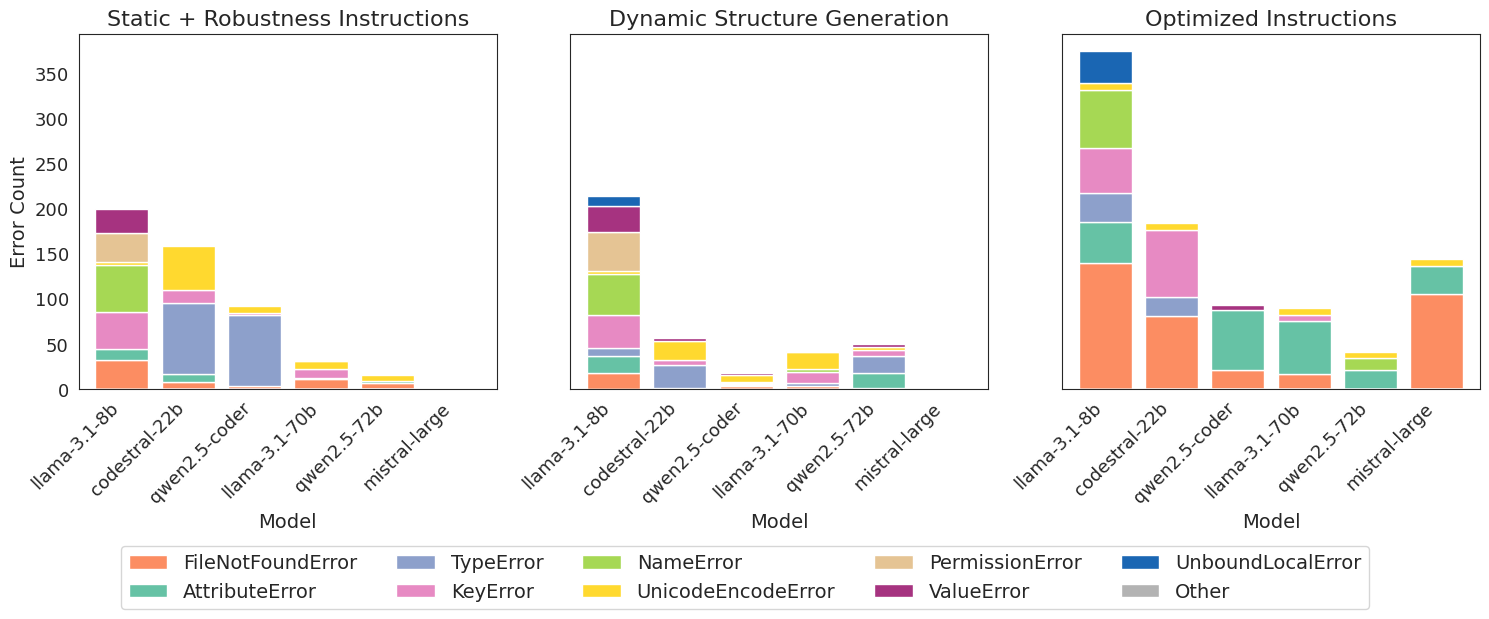

In [15]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

top_errors = ( df_errors["Error Type"] .value_counts() .nlargest(9) .index .tolist() )

all_error_types = top_errors + ["Other"]

set2 = sns.color_palette("Set2", n_colors=8)
reserved_orange = set2[1]
other_color = set2[-1]

palette_for_others = [c for i, c in enumerate(set2[:-1]) if i != 1]

extra_colors = [(0.65, 0.2, 0.5), (0.1, 0.4, 0.7)]

top_colors = []
for err in top_errors:
    if err == "FileNotFoundError":
        top_colors.append(reserved_orange)
    else:
        if palette_for_others:
            top_colors.append(palette_for_others.pop(0))
        else:
            top_colors.append(extra_colors.pop(0))

color_dict = dict(zip(top_errors, top_colors))
color_dict["Other"] = other_color

n_exps = len(experiment_titles)
fig, axes = plt.subplots(1, n_exps, figsize=(5*n_exps, 6), sharey=True)

for i, label in enumerate(experiment_titles):
    ax = axes[i] if n_exps > 1 else axes
    df_e = df_errors[df_errors["Experiment"] == label].copy()
    
    pivot = df_e.groupby(["Model", "Error Type"]).size().unstack(fill_value=0)
    pivot = pivot.reindex(columns=all_error_types, fill_value=0)
    pivot = pivot.reindex(custom_order).fillna(0)
    
    pivot.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        color=[color_dict[c] for c in pivot.columns], 
        width=0.8, 
        legend=False
    )

    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Model", fontsize=14)
    ax.set_ylabel("Error Count" if i == 0 else "", fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment("right")

handles = [Patch(facecolor=color_dict[err]) for err in all_error_types]
fig.legend(
    handles,
    all_error_types,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.09),
    ncol=5,
    frameon=True,
    fontsize=14,
    title_fontsize=16,
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("Images/Error Type Distribution per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

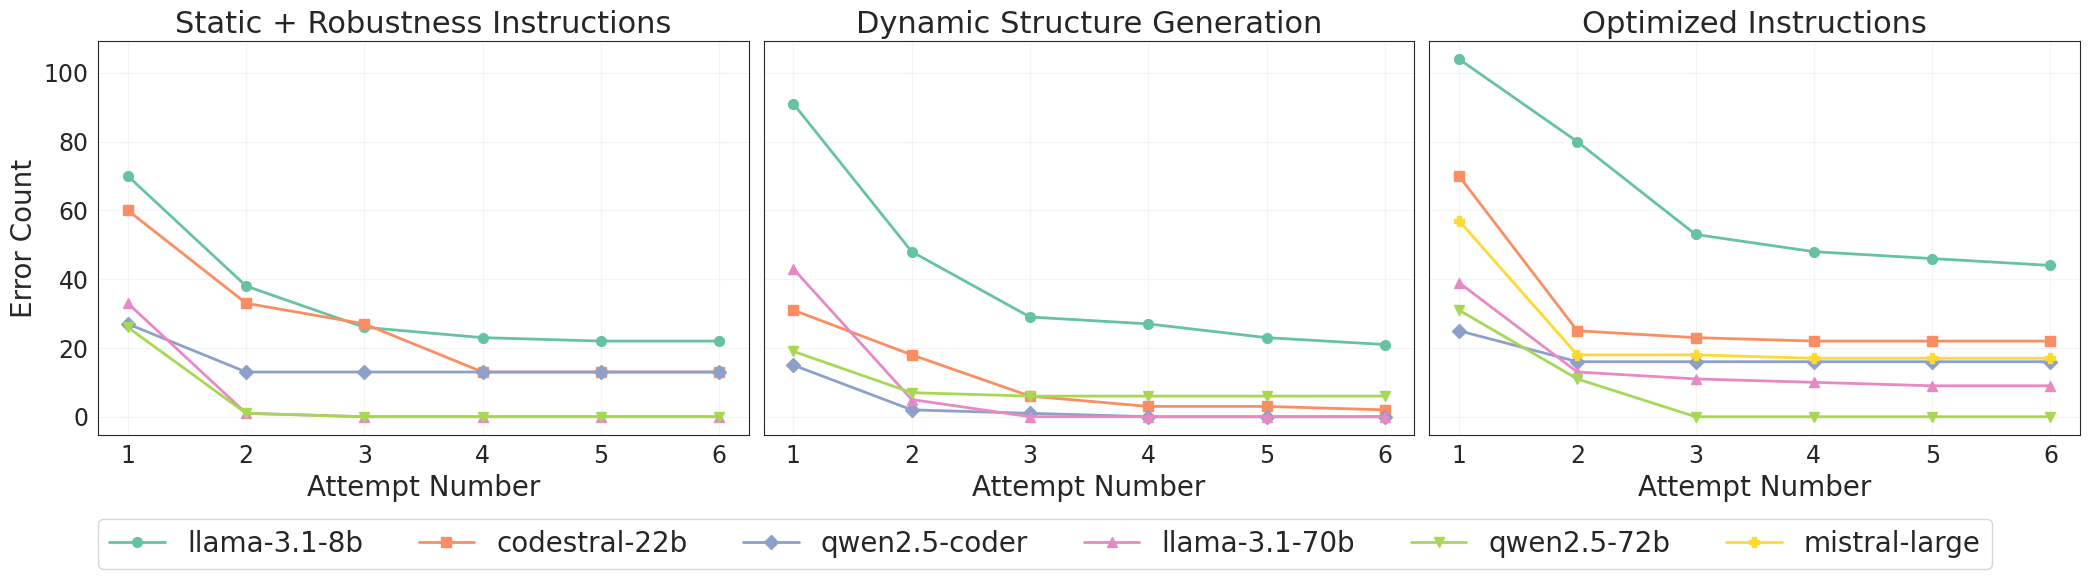

In [6]:
from matplotlib.colors import to_hex

markers = ["o", "s", "D", "^", "v", "P", "*", "X", "h", "<", ">"]
model_marker_map = {model: markers[i % len(markers)] for i, model in enumerate(custom_order)}

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))

model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

max_attempt = int(df_errors["Attempt Number"].max() if "Attempt Number" in df_errors.columns else 1)
fig, axes = plt.subplots(1, n_exps, figsize=(7 * n_exps, 6), sharey=True)

for i, label in enumerate(experiment_titles):
    ax = axes[i] if n_exps > 1 else axes
    df_e = df_errors[df_errors["Experiment"] == label].copy()
    if "Attempt Number" not in df_e.columns:
        ax.text(0.5, 0.5, "No Attempt Number column", ha="center", fontsize=16)
        continue

    trend = df_e.groupby(["Attempt Number", "Model"]).size().reset_index(name="Error Count")
    all_attempts = range(1, max_attempt+1)
    
    for model in custom_order:
        if model == "mistral-large" and i < 2:
            continue
        
        tmp = trend[trend["Model"] == model].set_index("Attempt Number").reindex(all_attempts, fill_value=0).reset_index()
        ax.plot(
            tmp["Attempt Number"],
            tmp["Error Count"],
            marker=model_marker_map[model],
            color=model_color_map[model],
            label=model,
            linestyle='-',
            linewidth=2,
            markersize=7
        )

    ax.set_title(label, fontsize=22)
    ax.set_xlabel("Attempt Number", fontsize=20)
    if i == 0:
        ax.set_ylabel("Error Count", fontsize=20)
    else:
        ax.set_ylabel("")
    
    if max_attempt > 10:
        ax.set_xticks([x for x in all_attempts if x % 2 == 1])
    else:
        ax.set_xticks(all_attempts)
    
    ax.tick_params(axis='x', labelsize=17)
    ax.tick_params(axis='y', labelsize=17)
    ax.grid(alpha=0.2)

    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment("center")

handles, labels_ = [], []
for ax in (axes if n_exps > 1 else [axes]):
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels_.extend(l)

unique = dict(zip(labels_, handles))
fig.legend(
    unique.values(),
    unique.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, -0.06),
    ncol=min(6, len(unique)),
    fontsize=20,
    frameon=True
)

plt.tight_layout(rect=[0, 0.05, 1, 0.92])  # leave room for legend
#plt.savefig("Images/Error Trend Over Attempts.png", dpi=600, bbox_inches='tight') 
plt.show()

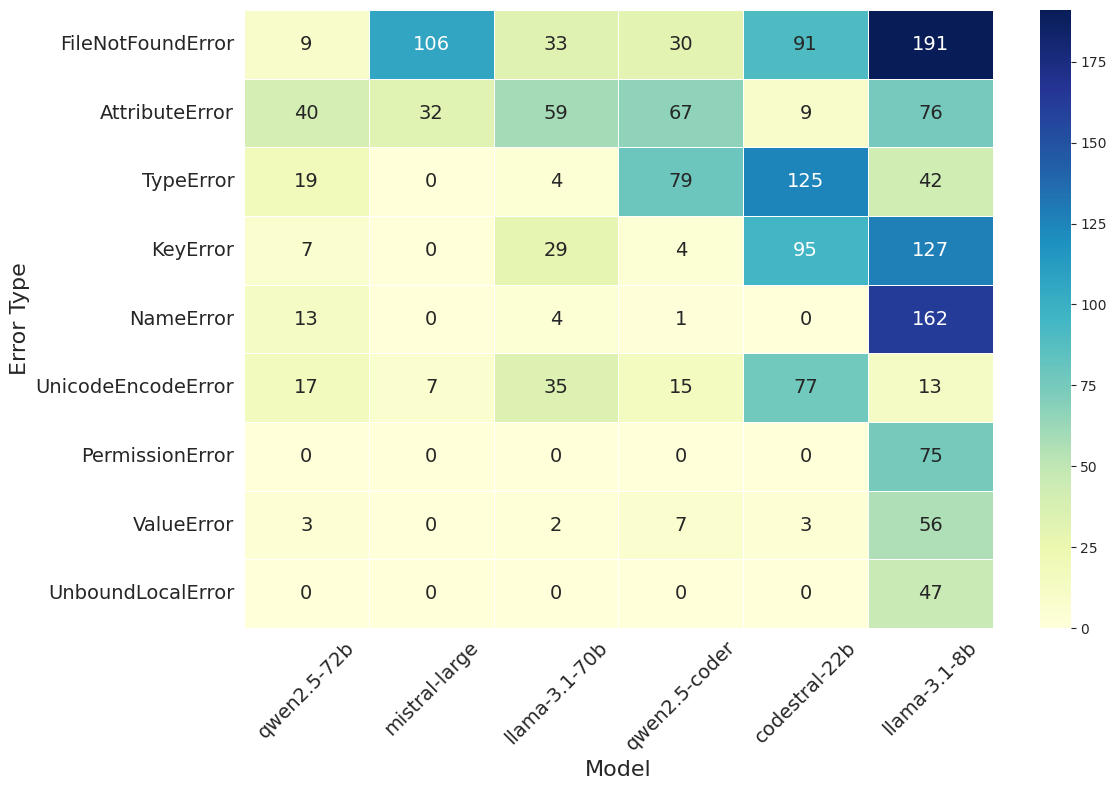

In [47]:
error_dfs = []

for path in experiment_dirs:
    df_error = pd.read_csv(f"{path}/processed_error_log.csv")
    df_error["Model"] = df_error["Model"].map(model_labels)
    error_dfs.append(df_error)

df_errors_all = pd.concat(error_dfs, ignore_index=True)

error_counts = (
    df_errors_all.groupby(["Error Type", "Model"])
    .size()
    .reset_index(name="Count")
)

heatmap_data = error_counts.pivot(index="Error Type", columns="Model", values="Count").fillna(0)

row_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
col_totals = heatmap_data.sum(axis=0).sort_values(ascending=True)

heatmap_sorted = heatmap_data.loc[row_totals.index, col_totals.index]

heatmap_top9 = heatmap_sorted.head(9)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_top9,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white",
    annot_kws={"fontsize": 14}
)

plt.xlabel("Model", fontsize=16)
plt.ylabel("Error Type", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("Images/Error Type Frequency per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

In [48]:
# Persistent Errors, Errors that appear 6 times in a failing instance
error_streaks = df_errors_all.groupby(["Experiment ID", "Error Type"]).size().reset_index(name="Occurrences")

max_persistence = error_streaks[error_streaks["Occurrences"] == 6]

unique_error_types_df = max_persistence[["Error Type"]].drop_duplicates().reset_index(drop=True)
display(unique_error_types_df)

,Error Type
0,FileNotFoundError
1,UnboundLocalError
2,TypeError
3,AttributeError
4,PermissionError
5,ParserError
6,NameError
7,KeyError
8,ValueError
9,SyntaxError


Summary of Top Errors on First Attempt:
Error Type
FileNotFoundError     159
NameError             120
UnicodeEncodeError    120
KeyError              111
AttributeError         88
TypeError              69
ValueError             23
PermissionError        13
UnknownError           12
NotADirectoryError     11
UnboundLocalError       8
SyntaxError             4
IndexError              2
ParserError             2
Name: count, dtype: int64


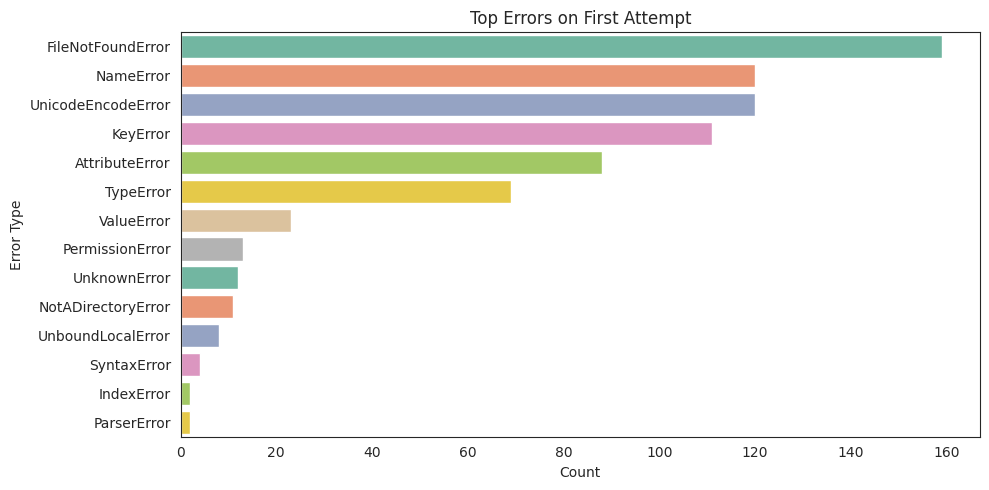

In [49]:
first_attempt_errors = df_errors_all[df_errors_all["Attempt Number"] == 1]
top_first_errors = first_attempt_errors["Error Type"].value_counts()

print("Summary of Top Errors on First Attempt:")
print(top_first_errors)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_first_errors.values, y=top_first_errors.index, palette="Set2")
plt.title("Top Errors on First Attempt")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

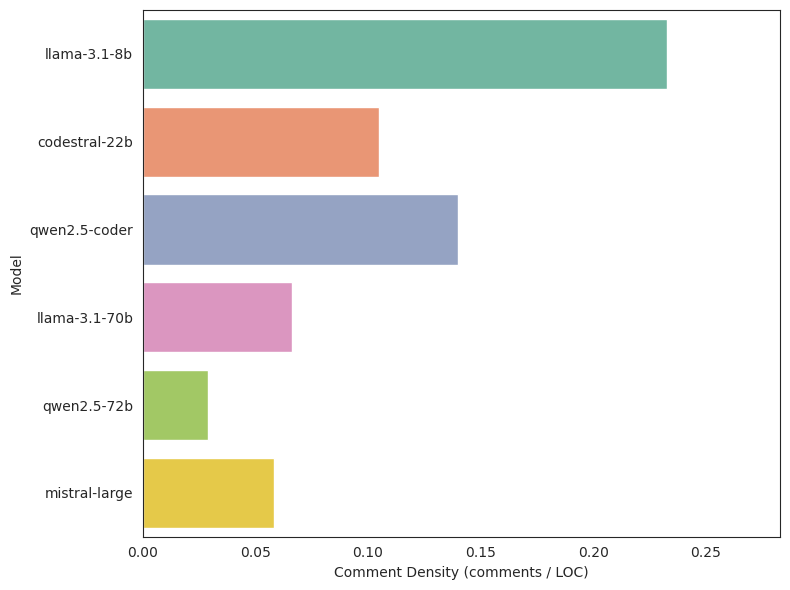

In [50]:
from matplotlib.colors import to_hex

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))

model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

all_dfs = []

for path in experiment_dirs:
    df = pd.read_csv(f"{path}/code_evaluation_log.csv", na_values=["", " "])
    df["Model"] = df["Model"].map(model_labels)
    all_dfs.append(df)

df_code = pd.concat(all_dfs, ignore_index=True)
df_code["comment_density"] = df_code["raw_comments"] / df_code["raw_loc"]

comment_summary = df_code.groupby("Model")["comment_density"].mean().round(3)
comment_summary = comment_summary.reindex(custom_order)

recommended_density = 0.2  # Common best practice is 15–25%

plt.figure(figsize=(8, 6))
sns.barplot(
    y=comment_summary.index,
    x=comment_summary.values,
    palette=[model_color_map[model] for model in comment_summary.index],
    orient='h'
)

plt.xlabel("Comment Density (comments / LOC)")
plt.ylabel("Model")
plt.xlim(0, max(comment_summary.values.max(), recommended_density) + 0.05)
plt.tight_layout()
#plt.savefig("Images/Comment Density.png", dpi=600, bbox_inches='tight') 
plt.show()

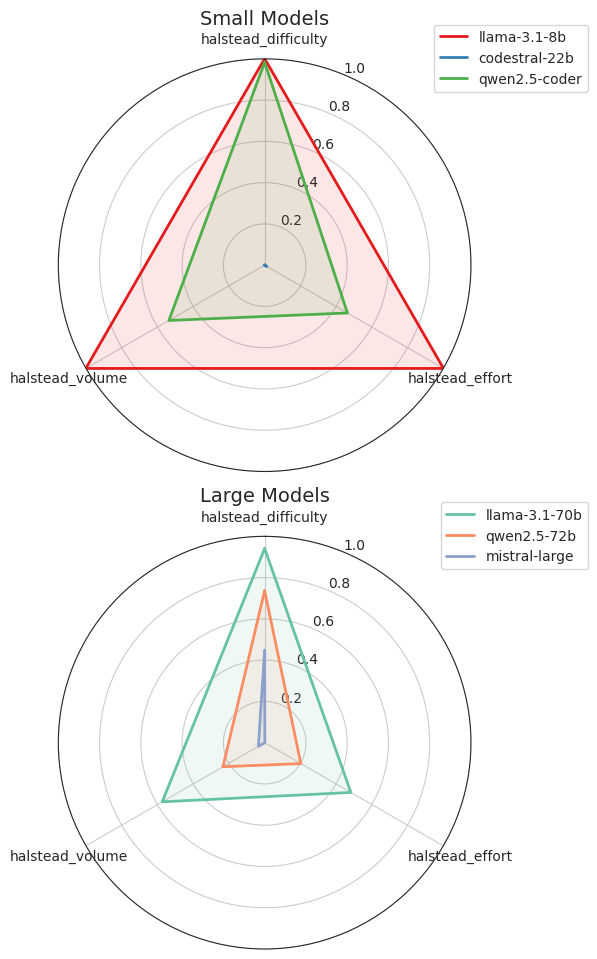

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

halstead_cols = ["halstead_difficulty", "halstead_effort", "halstead_volume"]
all_code_dfs = []

for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

halstead_summary = df_code_all.groupby("Model")[halstead_cols].mean()

scaler = MinMaxScaler()
halstead_normalized = pd.DataFrame(
    scaler.fit_transform(halstead_summary),
    index=halstead_summary.index,
    columns=halstead_summary.columns
)
halstead_normalized += 1e-3  # Small offset to avoid full collapse

labels = halstead_cols
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axs = plt.subplots(2, 1, figsize=(12, 10), subplot_kw=dict(polar=True))

palette_small = sns.color_palette("Set1", len(small_models))
palette_large = sns.color_palette("Set2", len(large_models))

for i, group in enumerate(model_groups):
    ax = axs[i]
    colors = palette_small if i == 0 else palette_large

    for j, model in enumerate(group):
        if model in halstead_normalized.index:
            values = halstead_normalized.loc[model].tolist()
            values += values[:1]  # close the loop
            ax.plot(angles, values, label=model, linewidth=2, color=colors[j])
            ax.fill(angles, values, alpha=0.1, color=colors[j])
        else:
            print(f"⚠️ Model '{model}' not found!")

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title("Small Models" if i == 0 else "Large Models", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig("Images/Halstead_Radar_Vertical.png", dpi=600, bbox_inches='tight')
plt.show()

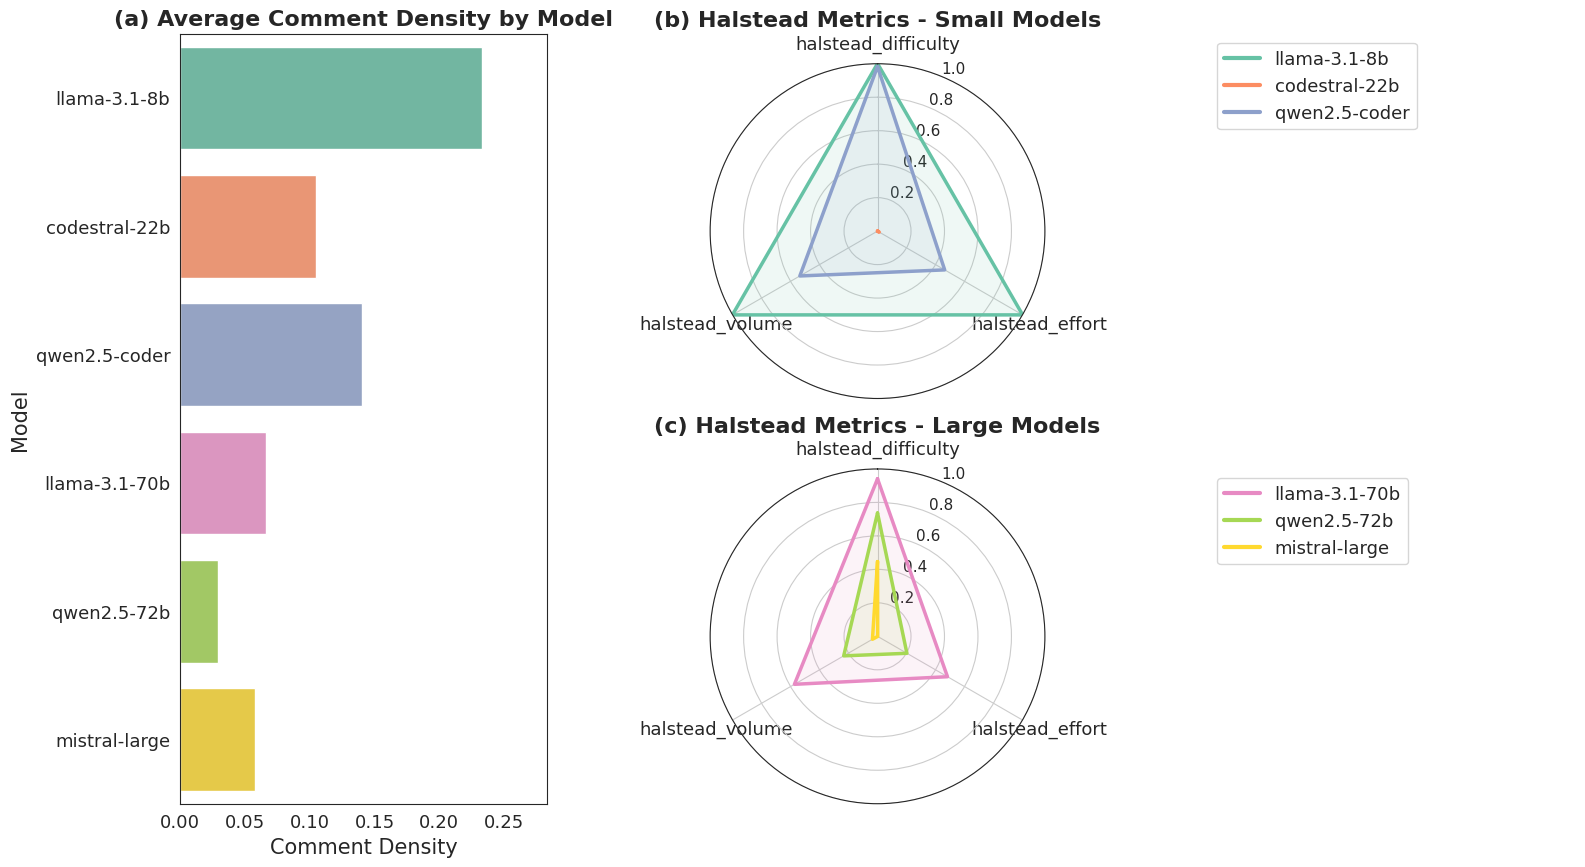

In [52]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
import pandas as pd

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))
model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], hspace=0.3, wspace=0.4)

ax_bar = fig.add_subplot(gs[:, 0])
sns.barplot(
    y=comment_summary.index,
    x=comment_summary.values,
    palette=[model_color_map[m] for m in comment_summary.index],
    orient='h',
    ax=ax_bar
)
ax_bar.set_xlabel("Comment Density", fontsize=15)
ax_bar.set_ylabel("Model", fontsize=15)
ax_bar.set_xlim(0, max(comment_summary.values.max(), 0.2) + 0.05)
ax_bar.set_title("(a) Average Comment Density by Model", fontsize=16, fontweight="bold")
ax_bar.tick_params(axis='both', labelsize=13)

for i, group in enumerate(model_groups):
    ax_radar = fig.add_subplot(gs[i, 1], polar=True)
    group_models = [m for m in group if m in halstead_normalized.index]

    for model in group_models:
        values = halstead_normalized.loc[model].tolist()
        values += values[:1]
        color = model_color_map.get(model, "#999999")
        ax_radar.plot(angles, values, label=model, linewidth=2.5, color=color)
        ax_radar.fill(angles, values, alpha=0.1, color=color)

    ax_radar.set_theta_offset(np.pi / 2)
    ax_radar.set_theta_direction(-1)
    ax_radar.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=13)
    ax_radar.set_ylim(0, 1)
    ax_radar.yaxis.set_tick_params(labelsize=11)
    ax_radar.set_title(
        "(b) Halstead Metrics - Small Models" if i == 0 else "(c) Halstead Metrics - Large Models",
        fontsize=16,
        fontweight="bold"
    )

    if i == 0:
        pos = ax_radar.get_position()
        ax_radar.set_position([pos.x0, pos.y0 - 0.03, pos.width, pos.height])

    ax_legend = fig.add_subplot(gs[i, 2])
    ax_legend.axis("off")

    legend_handles = [Line2D([0], [0], color=model_color_map[m], lw=3) for m in group_models]
    ax_legend.legend(
        legend_handles,
        group_models,
        loc='upper left',
        fontsize=13,
        frameon=True,
    )

plt.tight_layout()
#plt.savefig("Images/Comment_Density_and_Halstead_Radar.png", dpi=600, bbox_inches='tight')
plt.show()

In [53]:
import pandas as pd

comment_density_df = pd.DataFrame({
    "Model": comment_summary.index,
    "Comment Density (comments / LOC)": comment_summary.values.round(3)
})

print("Average Comment Density by Model:")
display(comment_density_df)


for i, group in enumerate(model_groups):
    print(f"\nHalstead Metrics for {'Small Models' if i == 0 else 'Large Models'}:")
    halstead_sub_df = halstead_normalized.loc[group].round(3)
    display(halstead_sub_df)

Average Comment Density by Model:


,Model,Comment Density (comments / LOC)
0,llama-3.1-8b,0.233
1,codestral-22b,0.105
2,qwen2.5-coder,0.140
3,llama-3.1-70b,0.066
4,qwen2.5-72b,0.029
5,mistral-large,0.058



Halstead Metrics for Small Models:


,halstead_difficulty,halstead_effort,halstead_volume
Model,,,
llama-3.1-8b,1.001,1.001,1.001
codestral-22b,0.001,0.012,0.001
qwen2.5-coder,0.983,0.463,0.536



Halstead Metrics for Large Models:


,halstead_difficulty,halstead_effort,halstead_volume
Model,,,
llama-3.1-70b,0.941,0.483,0.573
qwen2.5-72b,0.737,0.203,0.233
mistral-large,0.446,0.001,0.035


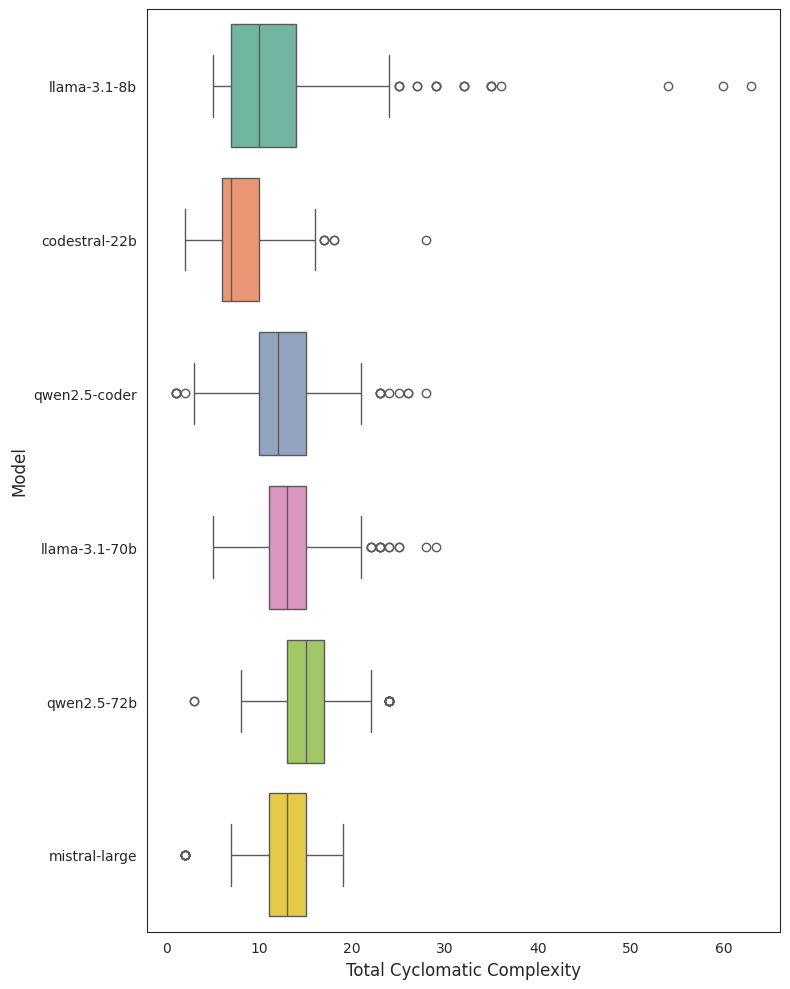

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_code_dfs = []

for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

plt.figure(figsize=(8, 10))
sns.boxplot(
    data=df_code_all,
    x="total_cyclomatic_complexity",
    y="Model",
    palette="Set2",
    order=custom_order
)

plt.xlabel("Total Cyclomatic Complexity", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.tight_layout()
#plt.savefig("Images/Cyclomatic Complexity Distribution per Model.png", dpi=600, bbox_inches='tight')
plt.show()

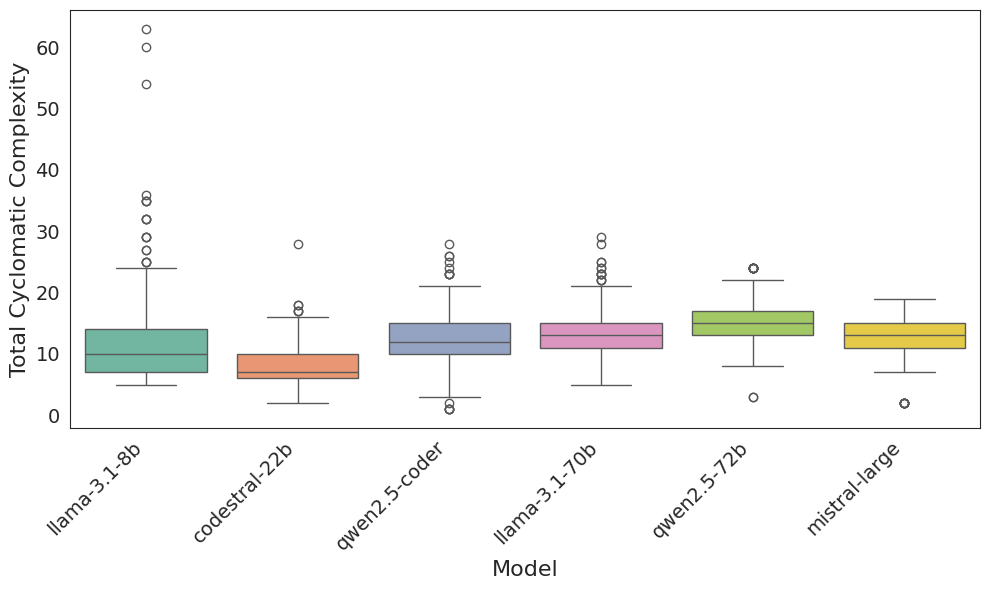

In [15]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(
    data=df_code_all,
    y="total_cyclomatic_complexity",
    x="Model",
    palette="Set2",
    order=custom_order
)

plt.ylabel("Total Cyclomatic Complexity", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("Images/Cyclomatic Complexity Distribution per Model.png", dpi=600, bbox_inches='tight')
plt.show()

In [16]:
import pandas as pd

summary_stats = df_code_all.groupby("Model")["total_cyclomatic_complexity"].describe()

summary_table = summary_stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].rename(columns={
    "count": "Count",
    "mean": "Mean",
    "std": "Std Dev",
    "min": "Min",
    "25%": "25th Percentile",
    "50%": "Median",
    "75%": "75th Percentile",
    "max": "Max"
})

summary_table = summary_table.round(2)

print("Summary statistics for Total Cyclomatic Complexity per Model:")
display(summary_table)

Summary statistics for Total Cyclomatic Complexity per Model:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
codestral-22b,430.0,7.91,3.21,2.0,6.0,7.0,10.0,28.0
llama-3.1-70b,459.0,12.98,3.50,5.0,11.0,13.0,15.0,29.0
llama-3.1-8b,381.0,11.94,7.12,5.0,7.0,10.0,14.0,63.0
mistral-large,139.0,12.94,3.85,2.0,11.0,13.0,15.0,19.0
qwen2.5-72b,462.0,14.84,3.65,3.0,13.0,15.0,17.0,24.0
qwen2.5-coder,439.0,13.06,4.15,1.0,10.0,12.0,15.0,28.0


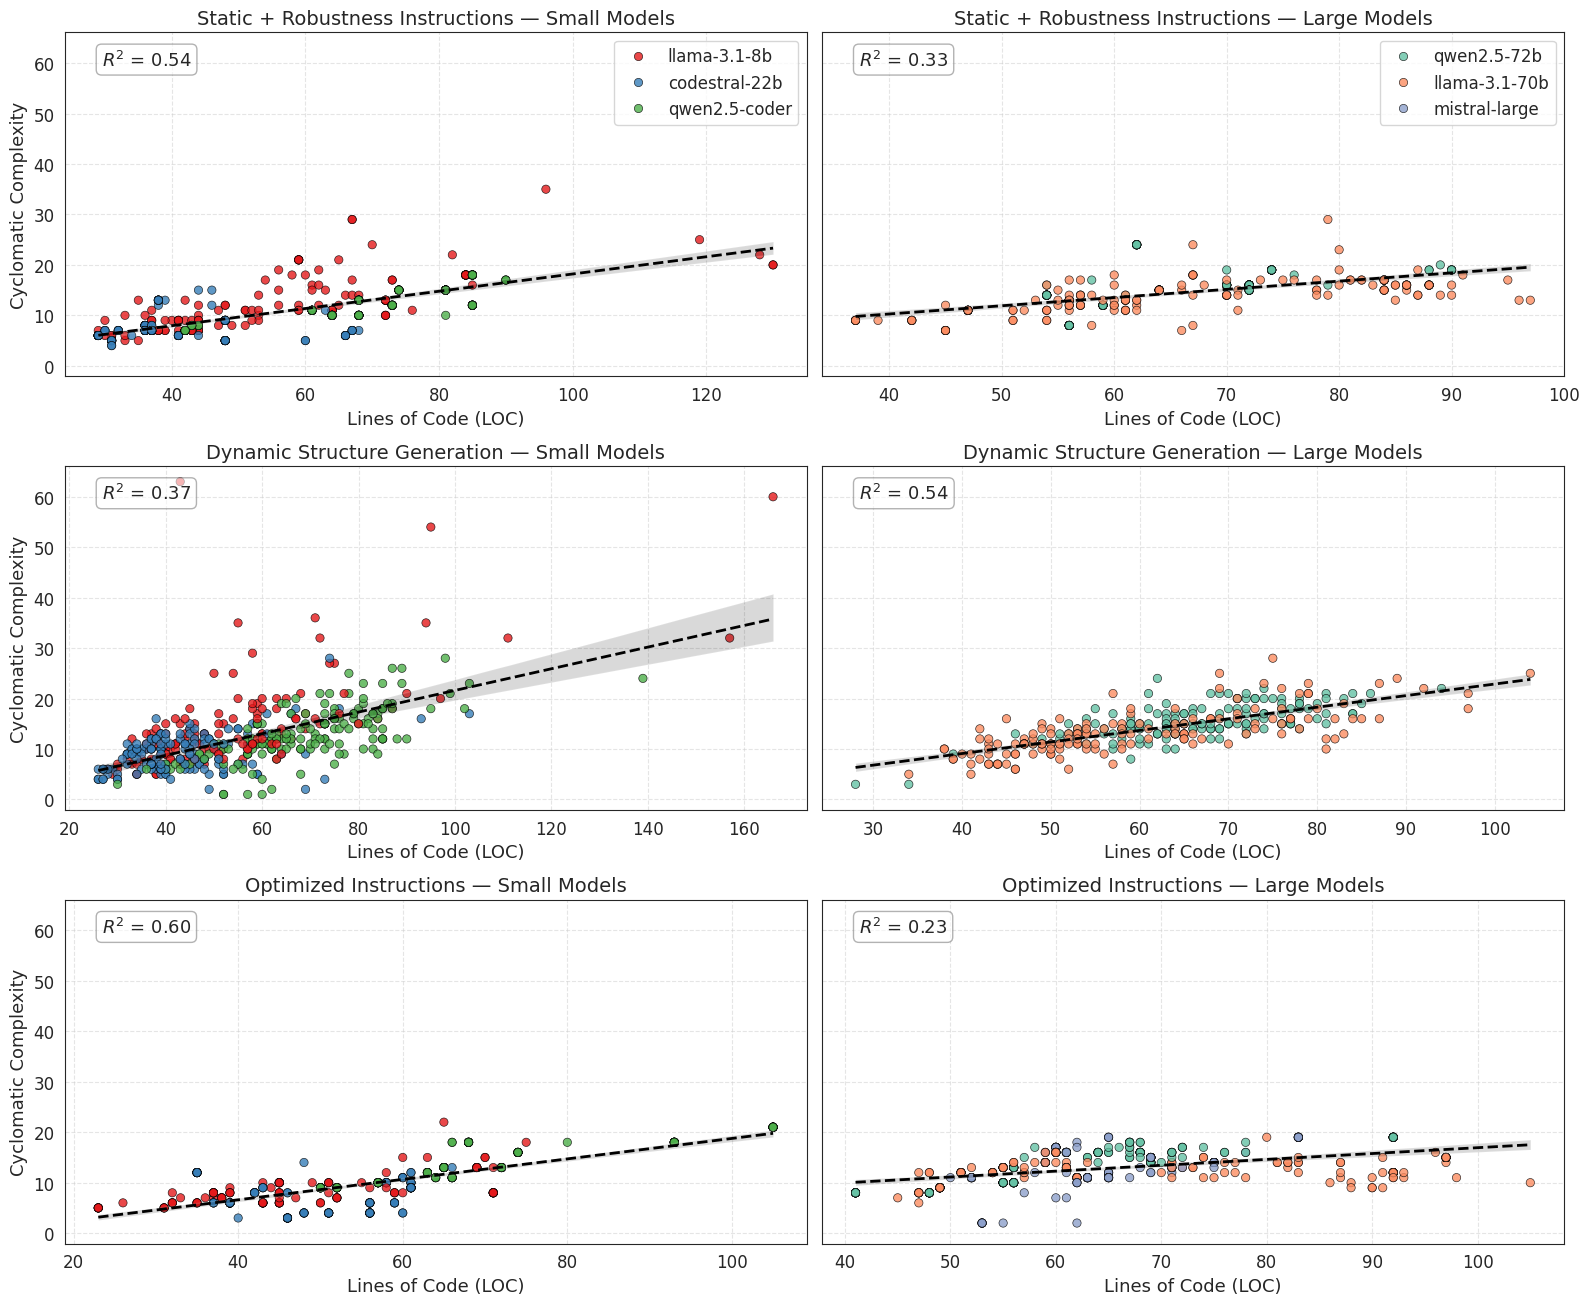

In [18]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import to_hex

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))
model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

all_code_dfs = []
for path in experiment_dirs:
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv")
    df_code["Experiment"] = path
    df_code["Model"] = df_code["Model"].map(model_labels)
    all_code_dfs.append(df_code)

df_code_all = pd.concat(all_code_dfs, ignore_index=True)

fig, axes = plt.subplots(3, 2, figsize=(16, 14), sharey=True)

def annotate_r2(df, ax):
    df = df.dropna(subset=["raw_loc", "total_cyclomatic_complexity"])
    if len(df) >= 2:
        x = df["raw_loc"].values.reshape(-1, 1)
        y = df["total_cyclomatic_complexity"].values
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        ax.text(
            0.05, 0.95,
            f"$R^2$ = {r2:.2f}",
            transform=ax.transAxes,
            fontsize=13,
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.6)
        )

for row_idx, (exp_dir, exp_title) in enumerate(zip(experiment_dirs, experiment_titles)):
    df_exp = df_code_all[df_code_all["Experiment"] == exp_dir]
    
    df_small = df_exp[df_exp["Model"].isin(small_models)]
    ax_small = axes[row_idx, 0]
    sns.scatterplot(
        data=df_small,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        hue="Model",
        palette="Set1",
        ax=ax_small,
        alpha=0.8,
        edgecolor="black"
    )
    sns.regplot(
        data=df_small,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        scatter=False,
        ax=ax_small,
        color="black",
        line_kws={"linewidth": 2, "linestyle": "--"}
    )
    annotate_r2(df_small, ax_small)
    ax_small.set_title(f"{exp_title} — Small Models", fontsize=14)
    ax_small.set_xlabel("Lines of Code (LOC)", fontsize=13)
    ax_small.set_ylabel("Cyclomatic Complexity", fontsize=13)
    ax_small.tick_params(axis='both', labelsize=12)
    ax_small.grid(True, linestyle="--", alpha=0.5)
    if row_idx != 0:
        ax_small.legend().remove()
    else:
        ax_small.legend(fontsize=12)       
    
    df_large = df_exp[df_exp["Model"].isin(large_models)]

    missing_models = [m for m in large_models if m not in df_large["Model"].unique()]
    dummy_df = pd.DataFrame({
        "raw_loc": [np.nan]*len(missing_models),
        "total_cyclomatic_complexity": [np.nan]*len(missing_models),
        "Model": missing_models
    })
    
    ax_large = axes[row_idx, 1]
    sns.scatterplot(
        data=pd.concat([df_large, dummy_df], ignore_index=True),
        x="raw_loc",
        y="total_cyclomatic_complexity",
        hue="Model",
        palette="Set2",
        ax=ax_large,
        alpha=0.8,
        edgecolor="black"
    )
    sns.regplot(
        data=df_large,
        x="raw_loc",
        y="total_cyclomatic_complexity",
        scatter=False,
        ax=ax_large,
        color="black",
        line_kws={"linewidth": 2, "linestyle": "--"}
    )
    annotate_r2(df_large, ax_large)
    ax_large.set_title(f"{exp_title} — Large Models", fontsize=14)
    ax_large.set_xlabel("Lines of Code (LOC)", fontsize=13)
    ax_large.set_ylabel("", fontsize=13)
    ax_large.tick_params(axis='both', labelsize=12)
    ax_large.grid(True, linestyle="--", alpha=0.5)
    if row_idx != 0:
        ax_large.legend().remove()
    else:
        ax_large.legend(fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#plt.savefig("Images/Cyc-LOC.png", dpi=600, bbox_inches='tight') 
plt.show()

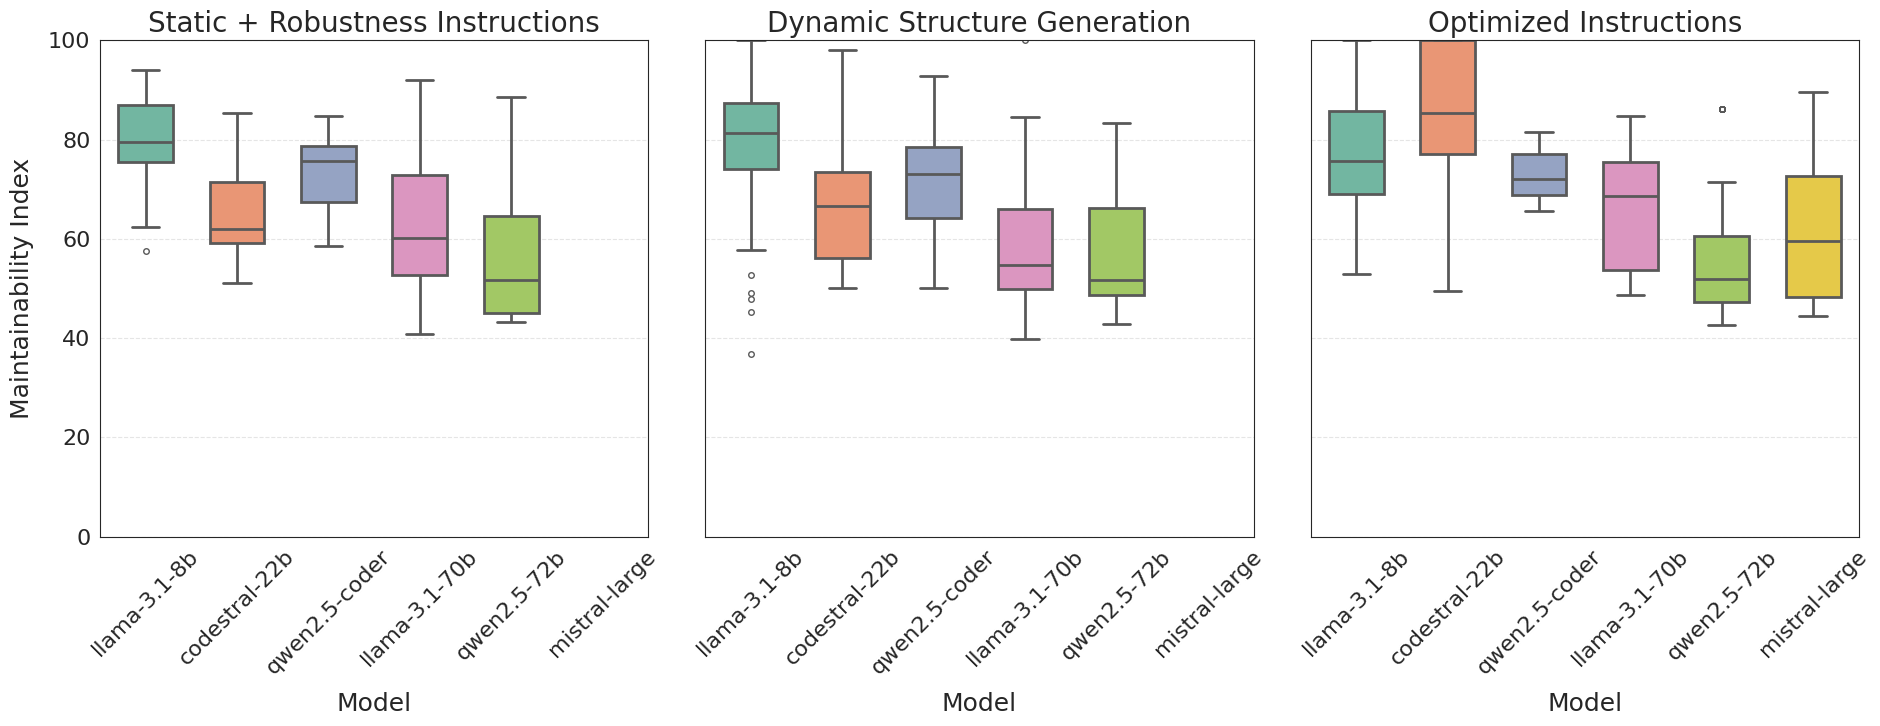

In [20]:
all_data = []

shared_palette = sns.color_palette("Set2", n_colors=len(custom_order))
model_color_map = dict(zip(custom_order, map(to_hex, shared_palette)))

for label, path in zip(experiment_titles, experiment_dirs):
    df_perf = pd.read_csv(f"{path}/processed_result_evaluation_log.csv", na_values=["", " "])
    df_perf = df_perf[df_perf["No Data"] == False]
    df_perf["F1"] = pd.to_numeric(df_perf["F1"], errors='coerce')
    df_perf["Model"] = df_perf["Model"].map(model_labels)
    
    df_code = pd.read_csv(f"{path}/code_evaluation_log.csv", na_values=["", " "])
    df_code["maintainability_index"] = pd.to_numeric(df_code["maintainability_index"], errors='coerce')
    df_code["Model"] = df_code["Model"].map(model_labels)

    
    df_merged = pd.merge(
        df_perf, df_code,
        on="Experiment ID",
        how="inner",
        suffixes=("_perf", "_code")
    )

    df_merged["Model"] = df_merged["Model_perf"]
    
    df_merged["Experiment"] = label
    all_data.append(df_merged)

df_all = pd.concat(all_data, ignore_index=True)

df_all["Model"] = pd.Categorical(df_all["Model"], categories=custom_order, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(19, 8), sharey=True)

for i, experiment in enumerate(experiment_titles):
    ax = axes[i]
    subset = df_all[df_all["Experiment"] == experiment]

    sns.boxplot(
        data=subset,
        x="Model",
        y="maintainability_index",
        ax=ax,
        palette=model_color_map,
        linewidth=2,
        fliersize=4,
        width=0.6
    )

    ax.set_title(experiment, fontsize=20)
    ax.set_xlabel("Model", fontsize=18, labelpad=10)
    ax.set_ylabel("Maintainability Index" if i == 0 else "", fontsize=18, labelpad=10)

    ax.tick_params(axis='x', labelsize=16, rotation=45)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("Images/Maintainability Index per Model.png", dpi=600, bbox_inches='tight') 
plt.show()

In [21]:
import pandas as pd

for experiment in experiment_titles:
    subset = df_all[df_all["Experiment"] == experiment]
    summary_stats = subset.groupby("Model")["maintainability_index"].describe()
    
    summary_table = summary_stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].rename(columns={
        "count": "Count",
        "mean": "Mean",
        "std": "Std Dev",
        "min": "Min",
        "25%": "25th Percentile",
        "50%": "Median",
        "75%": "75th Percentile",
        "max": "Max"
    }).round(2)
    
    print(f"Summary statistics for Maintainability Index - {experiment}:")
    display(summary_table)
    print("\n" + "="*80 + "\n")

Summary statistics for Maintainability Index - Static + Robustness Instructions:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
llama-3.1-8b,105.0,81.09,7.08,57.57,75.52,79.49,86.93,94.00
codestral-22b,112.0,64.35,9.66,51.09,59.07,62.03,71.48,85.40
qwen2.5-coder,112.0,73.42,7.42,58.53,67.40,75.65,78.76,84.79
llama-3.1-70b,125.0,62.06,10.51,40.81,52.75,60.21,72.89,92.02
qwen2.5-72b,125.0,55.29,12.14,43.25,45.15,51.66,64.56,88.53
mistral-large,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Summary statistics for Maintainability Index - Dynamic Structure Generation:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
llama-3.1-8b,108.0,79.51,11.61,36.77,74.03,81.40,87.43,100.00
codestral-22b,123.0,67.03,12.37,50.05,56.15,66.63,73.46,98.06
qwen2.5-coder,125.0,71.26,9.51,50.13,64.10,73.04,78.54,92.90
llama-3.1-70b,125.0,58.17,10.88,39.73,49.81,54.69,65.95,100.00
qwen2.5-72b,119.0,56.81,10.82,42.90,48.70,51.66,66.25,83.38
mistral-large,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Summary statistics for Maintainability Index - Optimized Instructions:


,Count,Mean,Std Dev,Min,25th Percentile,Median,75th Percentile,Max
Model,,,,,,,,
llama-3.1-8b,98.0,76.43,11.96,52.82,69.10,75.73,85.79,100.00
codestral-22b,105.0,83.83,14.05,49.47,77.17,85.34,100.00,100.00
qwen2.5-coder,111.0,73.33,5.24,65.51,68.77,72.01,77.16,81.45
llama-3.1-70b,116.0,66.02,11.50,48.75,53.64,68.70,75.41,84.83
qwen2.5-72b,125.0,54.65,11.45,42.60,47.36,51.91,60.67,86.18
mistral-large,122.0,61.15,14.53,44.41,48.22,59.58,72.67,89.64
